<h1 style="text-align: center;">Predictive Model for Home Prices Notebook</h1>

<p style="text-align: center; font-size: 18px;">By Diego Arévalo, Diego Osborn, Khoi Phan, &amp; Sardor Sobirov</p>

### Libraries

In [939]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from IPython.display import display
pd.options.display.max_columns = None

### Stat Libraries

In [942]:
from scipy.spatial import cKDTree
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import chain, combinations

### Visualization Libraries

In [945]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

### ML Libraries

In [948]:
# ML preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ML metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

## I Dataset

### I.i Identify a dataset

In [952]:
first_half = pd.read_csv('files/first_half.csv')
second_half = pd.read_csv('files/second_half.csv')
third_half = pd.read_csv('files/third_half.csv')
realtor_data = pd.concat([first_half, second_half, third_half]).reset_index(drop=True).iloc[:, 1:]
realtor_data[realtor_data.select_dtypes(include=['object']).columns] = realtor_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
display(realtor_data.head(5))

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,adjuntas,puerto rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,adjuntas,puerto rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,juana diaz,puerto rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,ponce,puerto rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,mayaguez,puerto rico,680.0,NaN,NaN


In [954]:
display(realtor_data.shape)
display(realtor_data.columns.tolist())
display(realtor_data.dtypes)

(2226382, 12)

['brokered_by',
 'status',
 'price',
 'bed',
 'bath',
 'acre_lot',
 'street',
 'city',
 'state',
 'zip_code',
 'house_size',
 'prev_sold_date']

brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

In [956]:
zipcode_land = pd.read_csv('files/national-zcta-data.csv', dtype={"GEOID": str})

In [958]:
display(zipcode_land.shape)
zipcode_land.columns = zipcode_land.columns.str.strip()
zipcode_land = zipcode_land.rename(columns={
    "GEOID": "zip_code",
    "ALAND_SQMI": "land_area",
    "AWATER_SQMI": "water_area",
    "INTPTLAT": "latitude",
    "INTPTLONG": "longitude"})
zipcode_land = zipcode_land.drop(columns=['ALAND', 'AWATER'])
display(zipcode_land.columns.tolist())
display(zipcode_land.dtypes)
display(zipcode_land.head(5))

(33791, 7)

['zip_code', 'land_area', 'water_area', 'latitude', 'longitude']

zip_code       object
land_area     float64
water_area    float64
latitude      float64
longitude     float64
dtype: object

,zip_code,land_area,water_area,latitude,longitude
0,601,64.416,0.308,18.180555,-66.749961
1,602,30.327,1.710,18.361945,-67.175597
2,603,34.356,2.414,18.457399,-67.124867
3,606,44.334,0.005,18.158327,-66.932928
4,610,37.124,1.656,18.295304,-67.125180


In [960]:
zipcode_pop = pd.read_excel('files/zip_population.xlsx', dtype={"Zip": str})

In [961]:
display(zipcode_pop.shape)
zipcode_pop.columns = zipcode_pop.columns.str.strip()
zipcode_pop = zipcode_pop.rename(columns={
    "Zip": "zip_code"})
zipcode_pop[zipcode_pop.select_dtypes(include=['object']).columns] = zipcode_pop.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
zipcode_pop = zipcode_pop.drop(columns=['CitySt', 'Coordinates', 'Country', 'State', 'County'])
display(zipcode_pop.columns.tolist())
display(zipcode_pop.dtypes)
display(zipcode_pop.head(5))

(40959, 12)

['zip_code', 'population', 'density', 'City', 'St', 'lat', 'long']

zip_code       object
population      int64
density       float64
City           object
St             object
lat           float64
long          float64
dtype: object

,zip_code,population,density,City,St,lat,long
0,92337,38868,1049.1,fontana,california,34.0498,-117.4706
1,92338,0,0.0,ludlow,california,34.7211,-116.1600
2,92339,1185,32.3,forest falls,california,34.0937,-116.9362
3,92340,1185,32.3,hesperia,california,34.4264,-117.3009
4,92341,203,22.4,green valley lake,california,34.2348,-117.0660


In [964]:
crime_data = pd.read_csv('files/fbi-crime.csv')
crime_data.columns = [re.sub(r'[^A-Za-z\s]', '', col).strip().replace('\n', '_').replace(' ', '_').lower() for col in crime_data.columns]
object_cols = ['population', 'violent_crime', 'robbery', 'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft', 'motor_vehicle_theft', 'arson']
for i in object_cols:
    crime_data[i] = crime_data[i].str.replace(',', '').astype(float)
crime_data[crime_data.select_dtypes(include=['object']).columns] = crime_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
crime_data = crime_data.fillna(0)
crime_data = crime_data.drop(columns=['rape_revised_definition', 'rape_legacy_definition'])
crime_data['state'] = crime_data['state'].str.replace(r'\d', '', regex=True).str.strip()
crime_data = crime_data.drop(columns=['murder_and_nonnegligent_manslaughter', 'robbery', 
                                      'aggravated_assault', 'burglary', 'larceny_theft', 
                                      'motor_vehicle_theft', 'arson'])
display(crime_data.columns.tolist())
display(crime_data.dtypes)
display(crime_data.head(5))

['state', 'city', 'population', 'violent_crime', 'property_crime']

state              object
city               object
population        float64
violent_crime     float64
property_crime    float64
dtype: object

,state,city,population,violent_crime,property_crime
0,alabama,abbeville,2610.0,9.0,76.0
1,alabama,adamsville,4414.0,25.0,330.0
2,alabama,addison,748.0,4.0,28.0
3,alabama,alabaster,31821.0,132.0,534.0
4,alabama,albertville,21534.0,30.0,723.0


In [966]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
}
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

uni_data = pd.read_csv('files/hd2023.csv', encoding='ISO-8859-1', na_values=['', ' '])
print(uni_data.shape)
uni_data = uni_data[['INSTNM', 'CITY', 'STABBR', 'ZIP', 'OBEREG','COUNTYNM', 'LONGITUD', 'LATITUDE', 'HLOFFER']]
uni_data.columns = [i.lower() for i in uni_data.columns]
uni_data = uni_data[uni_data['stabbr'].isin(us_state_to_abbrev.values())]
uni_data['stabbr'] = uni_data['stabbr'].map(abbrev_to_us_state)
uni_data[uni_data.select_dtypes(include=['object']).columns] = uni_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
uni_data['zip'] = uni_data['zip'].apply(lambda x: x[:5])
uni_data['hloffer'] = uni_data['hloffer'].apply(lambda x: -1 if x == 'b' else x).astype(int)
display(uni_data.columns.tolist())
display(uni_data.dtypes)
display(uni_data.head(5))

(6163, 73)


['instnm',
 'city',
 'stabbr',
 'zip',
 'obereg',
 'countynm',
 'longitud',
 'latitude',
 'hloffer']

instnm       object
city         object
stabbr       object
zip          object
obereg        int64
countynm     object
longitud    float64
latitude    float64
hloffer       int32
dtype: object

,instnm,city,stabbr,zip,obereg,countynm,longitud,latitude,hloffer
0,alabama a & m university,normal,alabama,35762,5,madison county,-86.568502,34.783368,9
1,university of alabama at birmingham,birmingham,alabama,35294,5,jefferson county,-86.799345,33.505697,9
2,amridge university,montgomery,alabama,36117,5,montgomery county,-86.174010,32.362609,9
3,university of alabama in huntsville,huntsville,alabama,35899,5,madison county,-86.640449,34.724557,9
4,alabama state university,montgomery,alabama,36104,5,montgomery county,-86.295677,32.364317,9


In [968]:
property_taxes = pd.read_csv('files/propertytax-by-state.csv')
property_taxes.columns = [i.strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for i in property_taxes.columns]
property_taxes['state'] = property_taxes['state'].str.lower()
property_taxes = property_taxes.drop(columns=['effective_tax_rate_2022'])
property_taxes['effective_tax_rate_2023'] = property_taxes['effective_tax_rate_2023'].str.replace('%', '').astype(float)
property_taxes = property_taxes.rename(columns={
    "effective_tax_rate_2023": "property_tax"})
display(property_taxes.columns.tolist())
display(property_taxes.dtypes)
display(property_taxes.head(5))

['state', 'property_tax', 'rank']

state            object
property_tax    float64
rank              int64
dtype: object

,state,property_tax,rank
0,alabama,0.38,49
1,alaska,1.14,16
2,arizona,0.52,45
3,arkansas,0.57,38
4,california,0.71,35


### I.ii Data cleaning

In [971]:
display(realtor_data.isnull().sum())

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

In [973]:
display(zipcode_land.isnull().sum())

zip_code      0
land_area     0
water_area    0
latitude      0
longitude     0
dtype: int64

Dropping rows with missing 'zip_code' since it can't be reliably filled in

In [976]:
realtor_data = realtor_data.dropna(subset=['zip_code'])

Filling NaN values of `price` steps:

1) Fill in missing prices with median zip code prices

2) Fill in missing prices with median state prices if the zip code group has all missing values

3) Fill in missing prices with global median prices as a final fallback

In [979]:
# 1)
zip_price = realtor_data.groupby('zip_code')['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(realtor_data['zip_code'].map(zip_price))

# 2)
state_price = realtor_data.groupby('state')['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(realtor_data['state'].map(state_price))

# 3)
global_price_median = realtor_data['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(global_price_median)

Filling NaN values of `bed` and `bath` steps:

1) Fill in missing beds and baths with median zip code beds and baths

2) Fill in missing beds and baths with median state beds and baths if the zip code group has all missing values

3) Fill in missing beds and baths with global median beds and baths as a final fallback

In [982]:
# 1)
zip_bed = realtor_data.groupby('zip_code')['bed'].median()
zip_bath = realtor_data.groupby('zip_code')['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(realtor_data['zip_code'].map(zip_bed))
realtor_data['bath'] = realtor_data['bath'].fillna(realtor_data['zip_code'].map(zip_bath))

# 2)
state_bed = realtor_data.groupby('state')['bed'].median()
state_bath = realtor_data.groupby('state')['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(realtor_data['state'].map(state_bed))
realtor_data['bath'] = realtor_data['bath'].fillna(realtor_data['state'].map(state_bath))

# 3)
global_bed_median = realtor_data['bed'].median()
global_bath_median = realtor_data['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(global_bed_median)
realtor_data['bath'] = realtor_data['bath'].fillna(global_bath_median)

Filling NaN values of `acre_lot` steps:

1) Fill in missing acreage with median zip code acreage

2) Fill in missing acreage with median state acreage if the zip code group has all missing values

3) Fill in missing acreage with global median acreage as a final fallback

In [985]:
# 1)
zip_acre = realtor_data.groupby('zip_code')['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(realtor_data['zip_code'].map(zip_acre))

# 2)
state_acre = realtor_data.groupby('state')['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(realtor_data['state'].map(state_acre))

# 3)
global_acre_median = realtor_data['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(global_acre_median)

Filling missing states with `Guam` because the zipcode 96999 is found in Guam1. Filtering `state` to only include US states and Washington DC and remove US territories and else (e.g. New Brunswick is a Canadian province)$^1$

In [988]:
non_us_states = ['puerto rico', 'virgin islands', 'guam', 'new brunswick']
realtor_data['state'] = realtor_data['state'].fillna('guam')
realtor_data = realtor_data[~realtor_data['state'].isin(non_us_states)].reset_index(drop=True)

Filling NaN values of `city` steps:

1) Fill in missing cities using zip code

2) Fill in missing acreage with state if the zip code group has all missing values

3) Drop rows where city is still missing as a final fallback

In [991]:
# 1)
zip_to_city = realtor_data.groupby('zip_code')['city'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
realtor_data['city'] = realtor_data['city'].fillna(realtor_data['zip_code'].map(zip_to_city))

# 2)
state_to_city = realtor_data.groupby('state')['city'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
realtor_data['city'] = realtor_data['city'].fillna(realtor_data['state'].map(state_to_city))

# 3)
realtor_data.dropna(subset=['city'], inplace=True)

Filling NaN values of `house_size` steps:

1) Fill in missing house sizes using zip code

2) Fill in missing house sizes with city if the zip code group has all missing values + created temporary `city_state` column to avoid city name ambiguity

3) Fill in missing house sizes with state as a final fallback

In [994]:
# 1)
zip_size = realtor_data.groupby('zip_code')['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['zip_code'].map(zip_size))

# 2)
realtor_data['city_state'] = realtor_data['city'] + ', ' + realtor_data['state']
city_state_size = realtor_data.groupby(['city', 'state'])['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['city_state'].map(city_state_size))

# 3)
state_size = realtor_data.groupby('state')['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['state'].map(state_size))

Convert `prev_sold_date` to datetime

In [997]:
realtor_data['prev_sold_date'] = pd.to_datetime(realtor_data['prev_sold_date'], errors='coerce')

Given that there are over 700_000 NaN values of `prev_sold_date`, these null values most likely exist represent that the homes have never been sold before, therefore we will create a binary indicator column `first_sale` where a 1 represents if the home has never been sold before (the NaN values) and 0 if it has (the non-NaN values).

In [1000]:
realtor_data['first_time'] = np.where(realtor_data['prev_sold_date'].isna(), 1, 0)
realtor_data['first_time'] = realtor_data['first_time'].astype('category')

Given that there were `prev_sold_date` dates that happened after the dataset `usa real estate data` was last updated, which was in 2024, those dates will be made NaN

In [1003]:
realtor_data.loc[realtor_data['prev_sold_date'] > '2024-01-01', 'prev_sold_date'] = pd.NaT

Filling NaN values of `prev_sold_date` steps:

1) Fill in missing previous sold dates using zip code

2) Fill in missing previous sold dates with city_state if the zip code group has all missing values

3) Fill in missing previous sold dates with state

4) Fill in missing previous sold dates with global median as a final fallback

drop `city_state` since it was a temporary column and we have cleaned the missing values of all of the features

In [1006]:
# 1)
zip_date = realtor_data.groupby('zip_code')['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['zip_code'].map(zip_date))

# 2)
city_state_date = realtor_data.groupby(['city', 'state'])['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['city_state'].map(city_state_date))

# 3)
state_date = realtor_data.groupby('state')['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['state'].map(state_date))

# 4) 
prev_sold_date_median = realtor_data['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(prev_sold_date_median)

# dropped temp col
realtor_data.drop(columns=['city_state'], inplace=True)

Cleaning up and normalizing the values of the categorical features

In [1009]:
categorical_cols = ['status', 'city', 'state']
realtor_data['status'] = realtor_data['status'].apply(lambda x: x.replace('_', ' '))
realtor_data[categorical_cols] = realtor_data[categorical_cols].apply(lambda x: x.str.strip().str.lower())

Changing types of `zip_code`, `bed`, `bath`, and `house_size` to `int`

In [1012]:
int_cols = ['bed', 'bath', 'house_size']
realtor_data[int_cols] = realtor_data[int_cols].astype(int)

Convert both the categorically encoded features `brokered_by` and `street` to strings and fill the NaN values with 'Not Specified'

In [1015]:
realtor_data['brokered_by'] = realtor_data['brokered_by'].astype(str)
realtor_data['brokered_by'].fillna('Not Specified', inplace=True)

realtor_data['street'] = realtor_data['street'].astype(str)
realtor_data['street'].fillna('Not Specified', inplace=True)

C:\Users\sardo\AppData\Local\Temp\ipykernel_4868\3682009116.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  realtor_data['brokered_by'].fillna('Not Specified', inplace=True)
C:\Users\sardo\AppData\Local\Temp\ipykernel_4868\3682009116.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

Changing types of the categorically encoded features and `zip_code` to `str`

In [1018]:
id_changer = lambda x: x.split('.')[0]

realtor_data['brokered_by'] = realtor_data['brokered_by'].astype(str).apply(id_changer)
realtor_data['street'] = realtor_data['street'].astype(str).apply(id_changer)
realtor_data['zip_code'] = realtor_data['zip_code'].astype(str).apply(id_changer)

Drop duplicates

In [1021]:
realtor_data = realtor_data.drop_duplicates(keep='first')

Merging the dataframe `zipcode_land` onto `realtor_data` to include `land_area` (in sq. miles), `water_area` (in sq. miles), and latitude & longitude for each `zip_code`.

In [1024]:
realtor_data = realtor_data.merge(zipcode_land, on="zip_code", how="left")

Merging the dataframe `zipcode_pop` onto `realtor_data` to include `population` and	`density` for each `zip_code`.

In [1027]:
realtor_data = realtor_data.merge(zipcode_pop, on='zip_code', how='left')

* Replacing `city` and `state` values with non-missing `City` and `St` values from `zipcode_pop` for cases where `zipcode_land` data was missing. Missing values in `zipcode_land` occured when there was an incorrect zipcode assignment--Kent, Washington, being incorrectly linked to a Los Angeles-area zipcode—-or a zipcode covered a niche area, such as Hat Island in Washington.

* Filling in most of the missing `latitude` and `longitude` values with `lat` and `long` from `zipcode_pop`, as both datasets were merged based on zip code.

* Since I used the `City`, `St`, `lat`, and `long` from `zipcode_pop` to help clean up the dataset more, they are no longer necessary.

In [1030]:
realtor_data.loc[(realtor_data['land_area'].isna()) & (realtor_data['City'].notna()), 'city'] = realtor_data['City']
realtor_data.loc[(realtor_data['land_area'].isna()) & (realtor_data['St'].notna()), 'state'] = realtor_data['St']

realtor_data.loc[realtor_data['latitude'].isna(), 'latitude'] = realtor_data.loc[realtor_data['latitude'].isna(), 'lat']
realtor_data.loc[realtor_data['longitude'].isna(), 'longitude'] = realtor_data.loc[realtor_data['longitude'].isna(), 'long']

realtor_data = realtor_data.drop(columns=['City', 'St', 'lat', 'long'])

Merging the dataframe `crime_data` onto `realtor_data` to include crime statistics for each `city_state` (a combinationation of city and state as a temp identifier).

In [1033]:
realtor_data['city_state'] = realtor_data['city']+', '+realtor_data['state']
crime_data['city_state'] = crime_data['city']+', '+crime_data['state']
realtor_data = realtor_data.merge(crime_data, on='city_state', how='left')

Getting rid of additional columns from the merge that are unnecessary and filtering `population` to only keep rows properties where the city has a population above 0.

In [1036]:
realtor_data = realtor_data.drop(columns=['city_state', 'state_y', 'city_y', 'population_y'])
realtor_data = realtor_data.rename(columns={
    "city_x": "city",
    "state_x": "state",
    "population_x": "population"})
realtor_data = realtor_data[realtor_data['population'] > 0]

Filling some NaN values of `land_area`, `water_area`, `latitude`, and `longitude` with the median for each (`city`, `state`) group

In [1039]:
city_state_medians = realtor_data.groupby(['city', 'state'])[['land_area', 'water_area', 'latitude', 'longitude']].median()
realtor_data = realtor_data.merge(city_state_medians, on=['city', 'state'], suffixes=('', '_median'))
for i in ['land_area', 'water_area', 'latitude', 'longitude']:
    realtor_data[i].fillna(realtor_data[f"{i}_median"], inplace=True)
realtor_data.drop(columns=[f"{i}_median" for i in ['land_area', 'water_area', 'latitude', 'longitude']], inplace=True)

C:\Users\sardo\AppData\Local\Temp\ipykernel_4868\589486439.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  realtor_data[i].fillna(realtor_data[f"{i}_median"], inplace=True)


Dropping the remaining rows where `latitude` and `longitude` are missing, as these correspond to non-existent areas, such as out of county, louisiana or out of county, california, or remote locations such as Naukati Bay, Alaska, or Kasaan, Alaska.

In [1042]:
realtor_data = realtor_data.dropna(subset=['latitude', 'longitude'])

Haversine function to calculate the great-circle distance between two coordinates in miles where 3958.8 is the Earth's radius in miles

In [1045]:
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

Merging `uni_data` onto `realtor_data` by grouping by zip code and computing the nearest university once for each unique zip code using the haversine distance formula and creating the features `closest_uni_name`, `closest_uni_lat`, `closest_uni_lon`, `closest_uni_zip`, `closest_uni_obereg`, `closest_uni_hloffer`, and `distance_to_uni` (sq miles).

In [1048]:
zip_coords = realtor_data[['zip_code', 'latitude', 'longitude']].dropna().drop_duplicates()

zip_to_uni = {}
for _, zip_row in tqdm(zip_coords.iterrows(), total=len(zip_coords)):
    lat1, lon1 = zip_row['latitude'], zip_row['longitude']
    uni_data['distance'] = haversine(lat1, lon1, uni_data['latitude'], uni_data['longitud'])
    nearest_uni = uni_data.loc[uni_data['distance'].idxmin()]
    zip_to_uni[zip_row['zip_code']] = {
        'closest_uni_name': nearest_uni['instnm'],
        'closest_uni_lat': nearest_uni['latitude'],
        'closest_uni_lon': nearest_uni['longitud'],
        'closest_uni_zip': nearest_uni['zip'],
        'closest_uni_obereg': nearest_uni['obereg'],
        'closest_uni_hloffer': nearest_uni['hloffer'],
        'distance_to_uni': nearest_uni['distance']}
zip_uni_df = pd.DataFrame.from_dict(zip_to_uni, orient='index').reset_index().rename(columns={'index': 'zip_code'})

realtor_data = realtor_data.merge(zip_uni_df, on='zip_code', how='left')
realtor_data['distance_to_uni'] = realtor_data['distance_to_uni'].apply(lambda x: x**2)

100%|███████████████████████████████████████████████████████████████████████████| 29835/29835 [01:50<00:00, 269.40it/s]


Creating a new feature `median_zip_price`, which represents the median price of homes in the zip code (helps compare listing prices to the market norm).

In [1051]:
median_zip_price = realtor_data[realtor_data['status'] == 'for sale'].groupby('zip_code')['price'].median().reset_index(name='median_zip_price')
realtor_data = realtor_data.merge(median_zip_price, on="zip_code", how="left")

Creating a new feature `inventory_count`, which represents the number of homes available for sale (low inventory → higher prices) by zip code.

In [1054]:
inventory_count = realtor_data[realtor_data['status'] == 'for sale'].groupby('zip_code').size().reset_index(name='inventory_count')
realtor_data = realtor_data.merge(inventory_count, on="zip_code", how="left")

Merging the nearest zip code (with available crime data) onto `realtor_data` by calculating the nearest zip code for each unique zip code using the haversine distance formula and creating the features `nearest_zip` and `nearest_zip_distance` (sq miles).

In [1057]:
zip_coords = realtor_data[['zip_code', 'latitude', 'longitude']].drop_duplicates()
ref_zips = realtor_data[~realtor_data['violent_crime'].isnull()][['zip_code', 'latitude', 'longitude']].drop_duplicates()

nearest_zip_map = {}
for _, zip_row in tqdm(zip_coords.iterrows(), total=len(zip_coords)):
    lat1, lon1 = zip_row['latitude'], zip_row['longitude']
    current_zip = zip_row['zip_code']
    candidate_zips = ref_zips[ref_zips['zip_code'] != current_zip].copy()
    if not candidate_zips.empty:
        candidate_zips['distance'] = haversine(lat1, lon1, candidate_zips['latitude'], candidate_zips['longitude'])
        nearest_zip = candidate_zips.loc[candidate_zips['distance'].idxmin()]
        nearest_zip_map[current_zip] = {'nearest_zip': nearest_zip['zip_code'], 'nearest_zip_distance': nearest_zip['distance']}
    else:
        nearest_zip_map[current_zip] = {'nearest_zip': np.nan, 'nearest_zip_distance': np.nan}

nearest_zip_df = pd.DataFrame.from_dict(nearest_zip_map, orient='index').reset_index().rename(columns={'index': 'zip_code'})
realtor_data = realtor_data.merge(nearest_zip_df, on='zip_code', how='left')
realtor_data['nearest_zip_distance'] = realtor_data['nearest_zip_distance'].apply(lambda x: x**2)

100%|███████████████████████████████████████████████████████████████████████████| 29835/29835 [04:06<00:00, 120.92it/s]


Filling NaN values of `violent_crime` and `property_crime` steps:

1) Fill in missing violent crime and property crime numbers using nearest zip code's violent_crime and property_crime numbers

2) Fill in missing violent crime and property crime numbers using state violent_crime and property_crime numbers as a final fallback

In [1059]:
zip_violent_crime = realtor_data.groupby('nearest_zip')['violent_crime'].median()
realtor_data['violent_crime'] = realtor_data['violent_crime'].fillna(realtor_data['nearest_zip'].map(zip_violent_crime))
state_violent_crime = realtor_data.groupby('state')['violent_crime'].median()
realtor_data['violent_crime'] = realtor_data['violent_crime'].fillna(realtor_data['state'].map(state_violent_crime))

zip_property_crime = realtor_data.groupby('nearest_zip')['property_crime'].median()
realtor_data['property_crime'] = realtor_data['property_crime'].fillna(realtor_data['nearest_zip'].map(zip_property_crime))
state_property_crime = realtor_data.groupby('state')['property_crime'].median()
realtor_data['property_crime'] = realtor_data['property_crime'].fillna(realtor_data['state'].map(state_property_crime))

realtor_data['total_crime'] = realtor_data['violent_crime'] + realtor_data['property_crime']

Creating new feature `total_crime` that sums up total `violent_crime` numbers and `property_crime` numbers for a given zip code to calculate `crime_rate` which is based on the formula: $\frac{\#\text{ of total crimes reported}}{\text{population}}\times 1,000$, meaning crime Rate per 1,000 inhabitants.

In [1062]:
realtor_data['total_crime'] = realtor_data['violent_crime'] + realtor_data['property_crime']
realtor_data['crime_rate'] = (realtor_data['total_crime']/realtor_data['population'])*1_000

Filling NaN values of `land_area` and `water_area` steps:

1) Fill in missing land_area and water_area sq miles using nearest zip code's land_area and water_area sq miles

2) Fill in missing land_area and water_area sq miles using state land_area and water_area sq miles as a final fallback

In [1065]:
zip_land_area = realtor_data.groupby('nearest_zip')['land_area'].median()
realtor_data['land_area'] = realtor_data['land_area'].fillna(realtor_data['nearest_zip'].map(zip_land_area))
state_land_area = realtor_data.groupby('state')['land_area'].median()
realtor_data['land_area'] = realtor_data['land_area'].fillna(realtor_data['state'].map(state_land_area))

zip_water_area = realtor_data.groupby('nearest_zip')['water_area'].median()
realtor_data['water_area'] = realtor_data['water_area'].fillna(realtor_data['nearest_zip'].map(zip_water_area))
state_water_area = realtor_data.groupby('state')['water_area'].median()
realtor_data['water_area'] = realtor_data['water_area'].fillna(realtor_data['state'].map(state_water_area))

Filling NaN values of `population` and `density` steps:

1) Fill in missing land_area and water_area sq miles using nearest zip code's land_area and water_area sq miles

2) Fill in missing land_area and water_area sq miles using state land_area and water_area sq miles as a final fallback

In [1068]:
zip_pop = realtor_data.groupby('nearest_zip')['population'].median()
realtor_data['population'] = realtor_data['population'].fillna(realtor_data['nearest_zip'].map(zip_pop))
state_pop = realtor_data.groupby('state')['population'].median()
realtor_data['population'] = realtor_data['population'].fillna(realtor_data['state'].map(state_pop))

zip_density = realtor_data.groupby('nearest_zip')['density'].median()
realtor_data['density'] = realtor_data['density'].fillna(realtor_data['nearest_zip'].map(zip_density))
state_density = realtor_data.groupby('state')['density'].median()
realtor_data['density'] = realtor_data['density'].fillna(realtor_data['state'].map(state_density))

Filling NaN values of `median_zip_price` and `inventory_count` steps:

1) Fill in missing median_zip_price and inventory_count using nearest zip code's median_zip_price and inventory_count numbers

2) Fill in missing median_zip_price and inventory_count using state median_zip_price and inventory_count numbers as a final fallback

In [1071]:
zip_median_zip_price = realtor_data.groupby('nearest_zip')['median_zip_price'].median()
realtor_data['median_zip_price'] = realtor_data['median_zip_price'].fillna(realtor_data['nearest_zip'].map(zip_median_zip_price))
state_median_zip_price = realtor_data.groupby('state')['median_zip_price'].median()
realtor_data['median_zip_price'] = realtor_data['median_zip_price'].fillna(realtor_data['state'].map(state_median_zip_price))

zip_inventory_count = realtor_data.groupby('nearest_zip')['inventory_count'].median()
realtor_data['inventory_count'] = realtor_data['inventory_count'].fillna(realtor_data['nearest_zip'].map(zip_inventory_count))
state_inventory_count = realtor_data.groupby('state')['inventory_count'].median()
realtor_data['inventory_count'] = realtor_data['inventory_count'].fillna(realtor_data['state'].map(state_inventory_count))

Merging the dataframe `property_taxes` onto `realtor_data` to include property taxes for each state

In [1074]:
realtor_data = realtor_data.merge(property_taxes, on='state', how='left')

In [1076]:
realtor_data.head(5)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,first_time,land_area,water_area,latitude,longitude,population,density,violent_crime,property_crime,closest_uni_name,closest_uni_lat,closest_uni_lon,closest_uni_zip,closest_uni_obereg,closest_uni_hloffer,distance_to_uni,median_zip_price,inventory_count,nearest_zip,nearest_zip_distance,total_crime,crime_rate,property_tax,rank
0,67832,for sale,180000.0,2,1,0.34,732726,agawam,massachusetts,1001,676,2021-11-30,1,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17
1,97400,for sale,25000.0,3,2,3.41,1909493,agawam,massachusetts,1001,1397,2021-11-30,1,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17
2,58796,for sale,169900.0,2,2,0.41,1194249,agawam,massachusetts,1001,892,2019-04-30,0,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17
3,8147,for sale,242000.0,2,2,0.41,913299,agawam,massachusetts,1001,1428,2021-11-30,1,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17
4,22700,for sale,299950.0,2,2,0.41,560791,agawam,massachusetts,1001,1659,2021-11-30,1,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17


In [1078]:
display(realtor_data.isnull().sum())

brokered_by             0
status                  0
price                   0
bed                     0
bath                    0
acre_lot                0
street                  0
city                    0
state                   0
zip_code                0
house_size              0
prev_sold_date          0
first_time              0
land_area               0
water_area              0
latitude                0
longitude               0
population              0
density                 0
violent_crime           0
property_crime          0
closest_uni_name        0
closest_uni_lat         0
closest_uni_lon         0
closest_uni_zip         0
closest_uni_obereg      0
closest_uni_hloffer     0
distance_to_uni         0
median_zip_price        0
inventory_count         0
nearest_zip             0
nearest_zip_distance    0
total_crime             0
crime_rate              0
property_tax            0
rank                    0
dtype: int64

Summary statistics + Outlier Removal

In [1081]:
def winsorize_col(x, lower_quantile=0.01, upper_quantile=0.99):
    lower = x.quantile(lower_quantile)
    upper = x.quantile(upper_quantile)
    return np.clip(x, lower, upper)

In [1083]:
summary_stats = realtor_data.describe().T
summary_stats['std'] = summary_stats['std'].apply(lambda x: f"{x:.6f}")
summary_stats['max'] = summary_stats['max'].apply(lambda x: f"{x:.1f}")
summary_stats['min'] = summary_stats['min'].apply(lambda x: f"{x:.1f}")
for i in ['25%', '50%', '75%']:
    summary_stats[i] = summary_stats[i].apply(lambda x: f"{x:.3f}")
display(summary_stats)

,count,mean,min,25%,50%,75%,max,std
price,2220527.0,522776.664706,0.0,165000.000,325000.000,550000.000,1000000000.0,1581069.310112
bed,2220527.0,3.230458,1.0,3.000,3.000,4.000,473.0,1.407296
bath,2220527.0,2.434484,1.0,2.000,2.000,3.000,830.0,1.477724
acre_lot,2220527.0,12.969577,0.0,0.150,0.250,0.760,100000.0,699.278383
house_size,2220527.0,4134.642164,4.0,1386.000,1764.000,2276.000,1040400400.0,1157885.216120
prev_sold_date,2220527,2016-06-21 12:32:32.052008704,.1f,.3f,.3f,.3f,.1f,nan
land_area,2220527.0,79.252337,0.0,10.153,30.988,86.787,13680.1,168.710580
water_area,2220527.0,2.570152,0.0,0.064,0.436,1.872,1426.1,9.497591
latitude,2220527.0,36.744744,19.1,33.010,37.117,40.865,71.3,5.536321
longitude,2220527.0,-92.259118,-164.7,-98.472,-87.605,-80.622,-67.0,15.885142


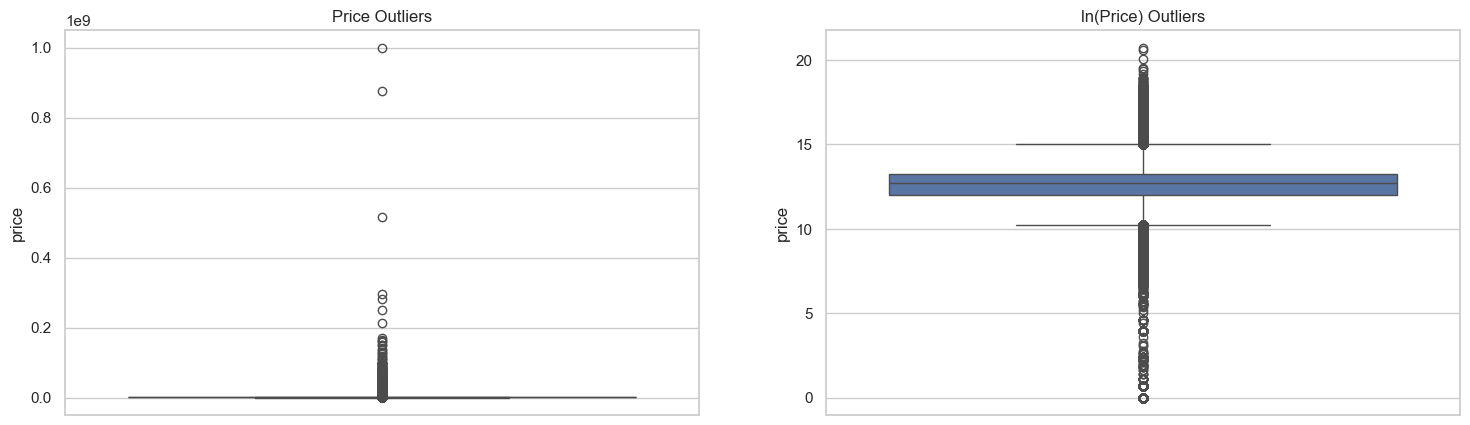

In [1085]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['price'], ax=axes[0]).set_title('Price Outliers')
sns.boxplot(y=np.log1p(realtor_data['price']), ax=axes[1]).set_title('ln(Price) Outliers')
plt.show()

From the summary statistics and the outlier plots we can see that the max `price` is $1\times 10^9$, which is \$1 billion, however this is not realistic because, as of February 2024, the most expensive home in the United States is Gordon Pointe in Naples, Florida, which is listed for \$295 million dollars$^2$. Therefore we can filter `realtor_data` to not include the outliers in `price` that are greater than \$295 million dollars.$^2$ We can also see that the min is 0.0, meaning the home was free, however, this is not realistic and to avoid data entry errors, the lowest threshold will be set at \$10,000.

...

In [1092]:
realtor_data = realtor_data[(realtor_data['price'] >= 1e4) & (realtor_data['price'] <= 2.95e8)]
realtor_data['price'] = winsorize_col(realtor_data['price'])

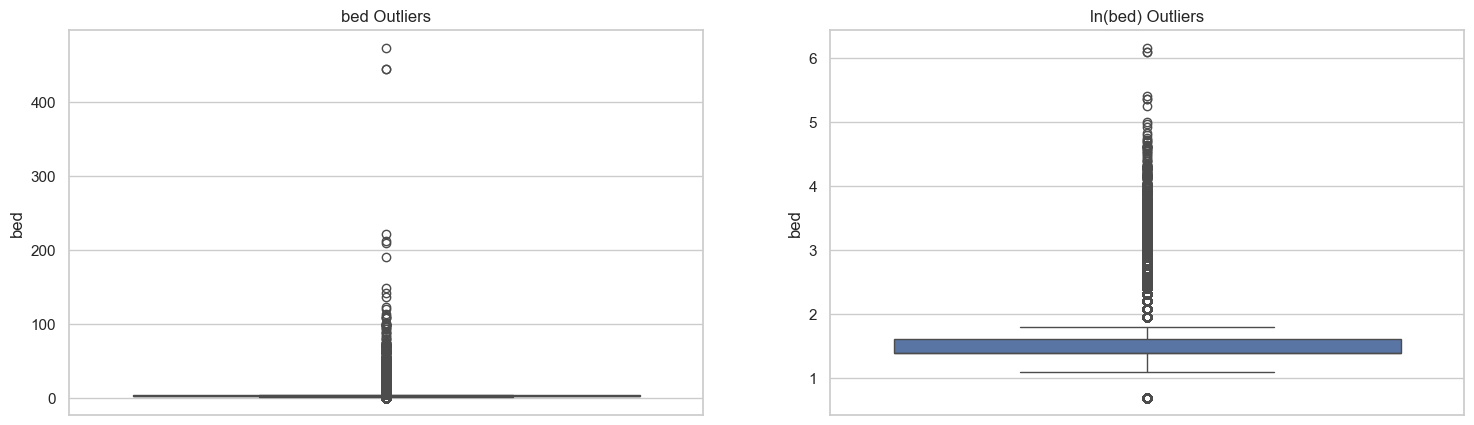

In [1093]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['bed'], ax=axes[0]).set_title('bed Outliers')
sns.boxplot(y=np.log1p(realtor_data['bed']), ax=axes[1]).set_title('ln(bed) Outliers')
plt.show()

From the summary statistics we can see that the max `bed` is $473$, however this is not realistic because the Biltmore Estate in Asheville, North Carolina has the most amount of bedrooms in the United States at 35 $^3$. Therefore we can filter `realtor_data` to not include the outliers in `bed` that are greater than $35$.$^3$

In [1097]:
realtor_data = realtor_data[realtor_data['bed']<=35]

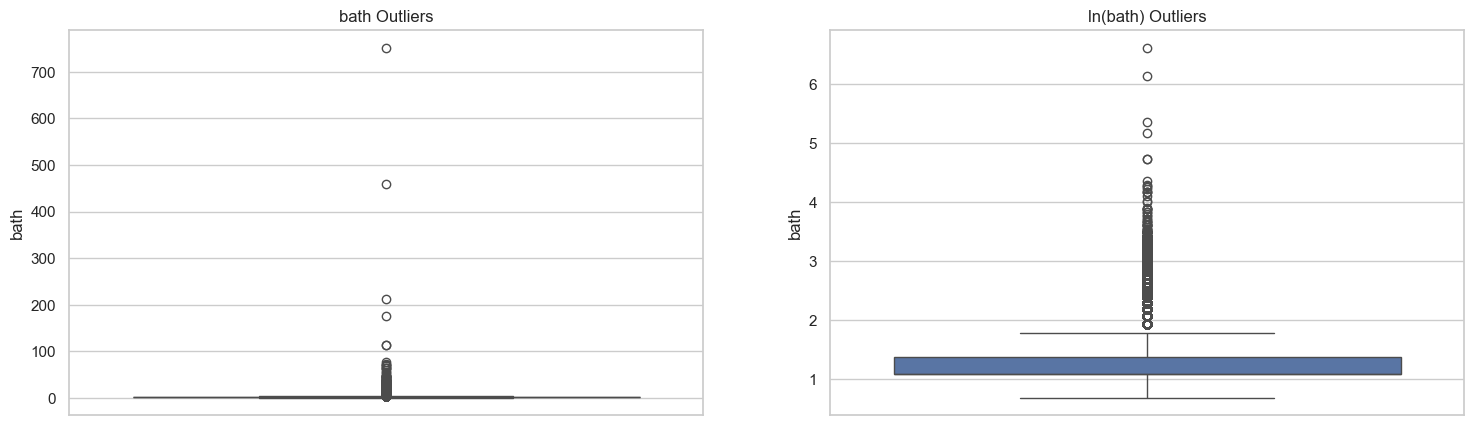

In [1099]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['bath'], ax=axes[0]).set_title('bath Outliers')
sns.boxplot(y=np.log1p(realtor_data['bath']), ax=axes[1]).set_title('ln(bath) Outliers')
plt.show()

From the summary statistics we can see that the max `bath` is $752$, however this is not realistic because The One in Bel Air, California has the most amount of bathrooms in the United States at 49$^4$. Therefore we can filter `realtor_data` to not include the outliers in `bath` that are greater than $49$.$^4$

In [1102]:
realtor_data = realtor_data[realtor_data['bath']<=49]

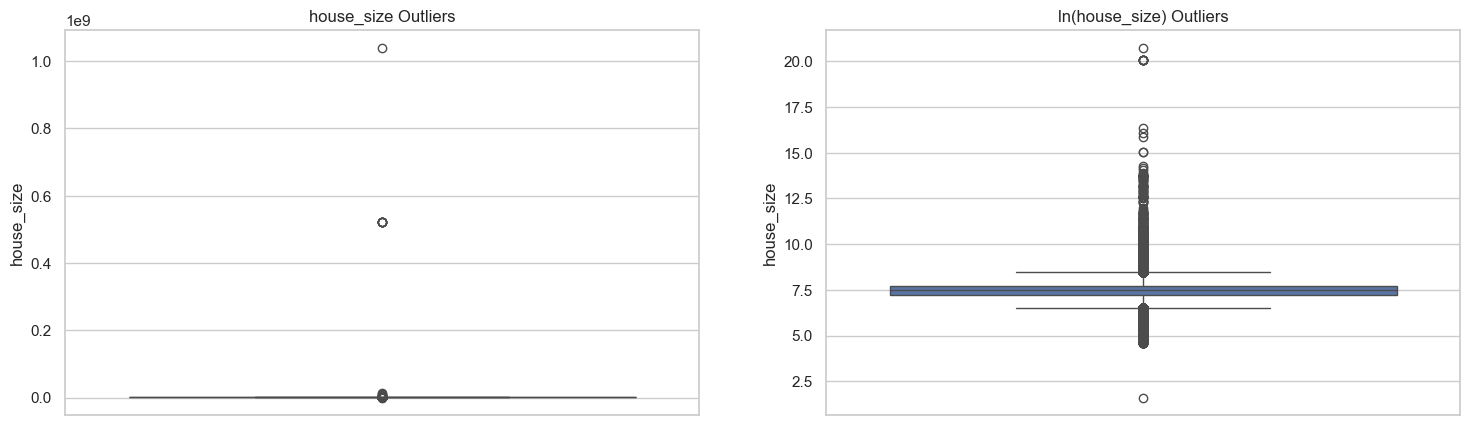

In [1104]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['house_size'], ax=axes[0]).set_title('house_size Outliers')
sns.boxplot(y=np.log1p(realtor_data['house_size']), ax=axes[1]).set_title('ln(house_size) Outliers')
plt.show()

From the summary statistics we can see that the max `house_size` is $1.0404004\times 10^9$, which is around 1.04 billion, however this is not realistic because the Biltmore Estate in Asheville, North Carolina, the largest home in the United States by square footage, is at 175,000 sq ft$^5$. Therefore we can filter `realtor_data` to not include the outliers in `house_size` that are greater than $175,000$.$^5$

In [1107]:
realtor_data = realtor_data[realtor_data['house_size']<=175_000]
realtor_data['house_size'] = winsorize_col(realtor_data['house_size'])

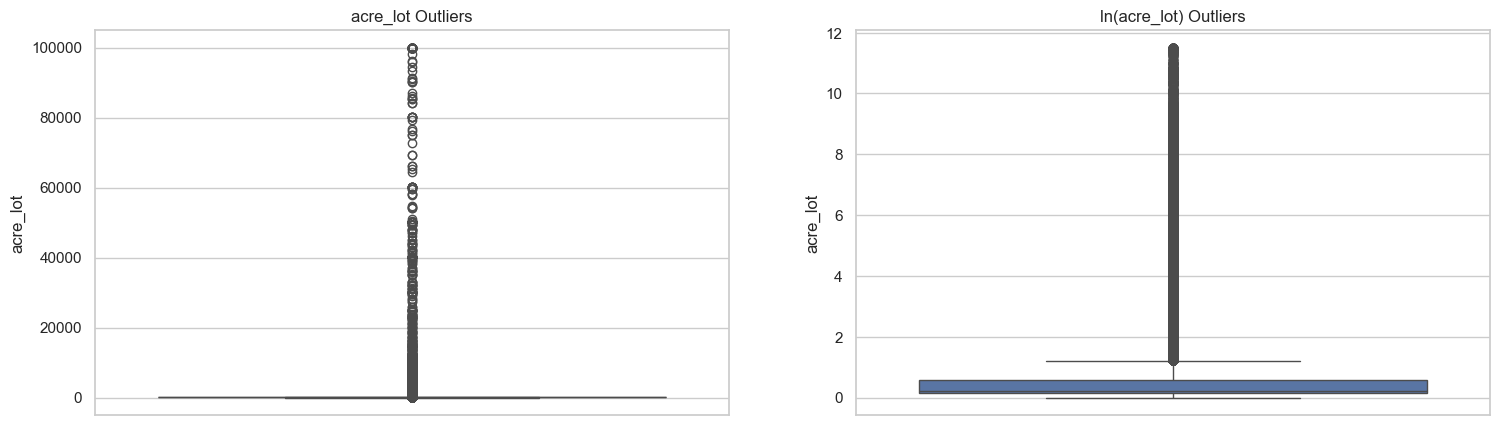

In [1108]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['acre_lot'], ax=axes[0]).set_title('acre_lot Outliers')
sns.boxplot(y=np.log1p(realtor_data['acre_lot']), ax=axes[1]).set_title('ln(acre_lot) Outliers')
plt.show()

...

In [1112]:
realtor_data['acre_lot'] = winsorize_col(realtor_data['acre_lot'])

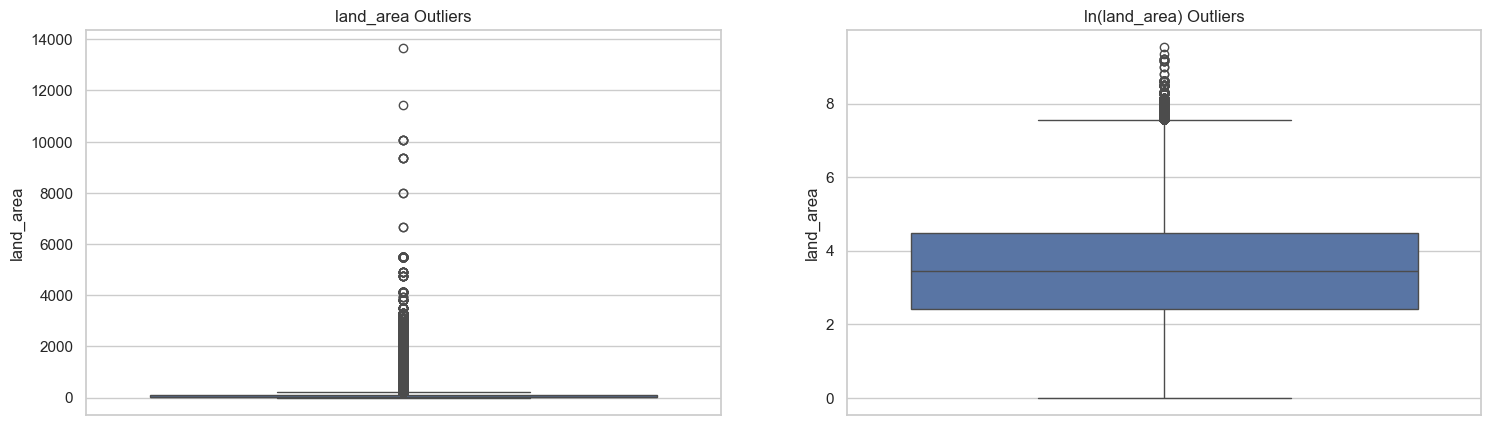

In [1114]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['land_area'], ax=axes[0]).set_title('land_area Outliers')
sns.boxplot(y=np.log1p(realtor_data['land_area']), ax=axes[1]).set_title('ln(land_area) Outliers')
plt.show()

In [1117]:
realtor_data['land_area'] = winsorize_col(realtor_data['land_area'])

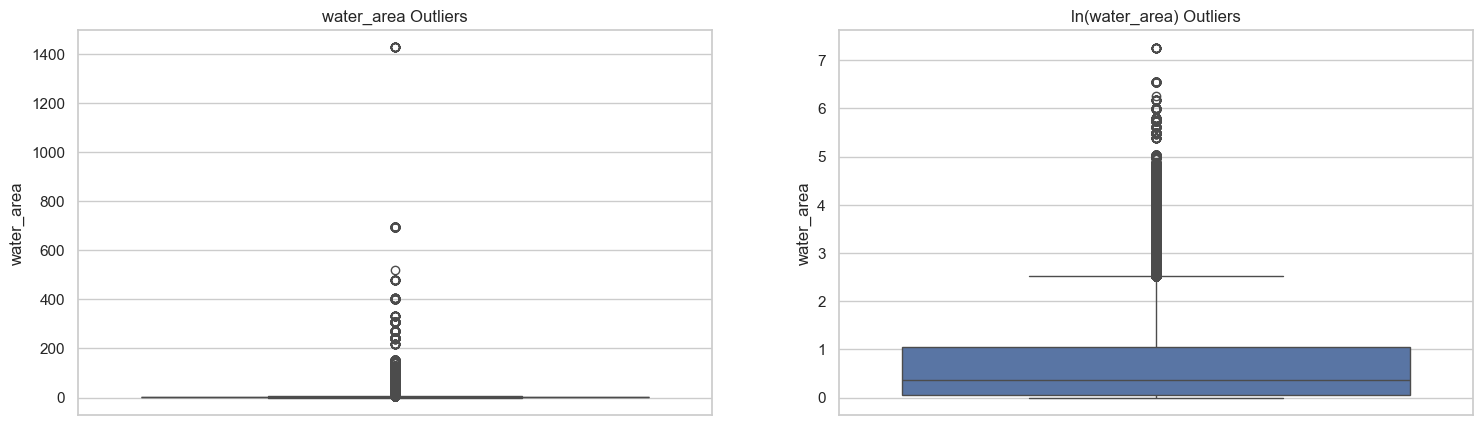

In [1119]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['water_area'], ax=axes[0]).set_title('water_area Outliers')
sns.boxplot(y=np.log1p(realtor_data['water_area']), ax=axes[1]).set_title('ln(water_area) Outliers')
plt.show()

In [1122]:
realtor_data['water_area'] = winsorize_col(realtor_data['water_area'])

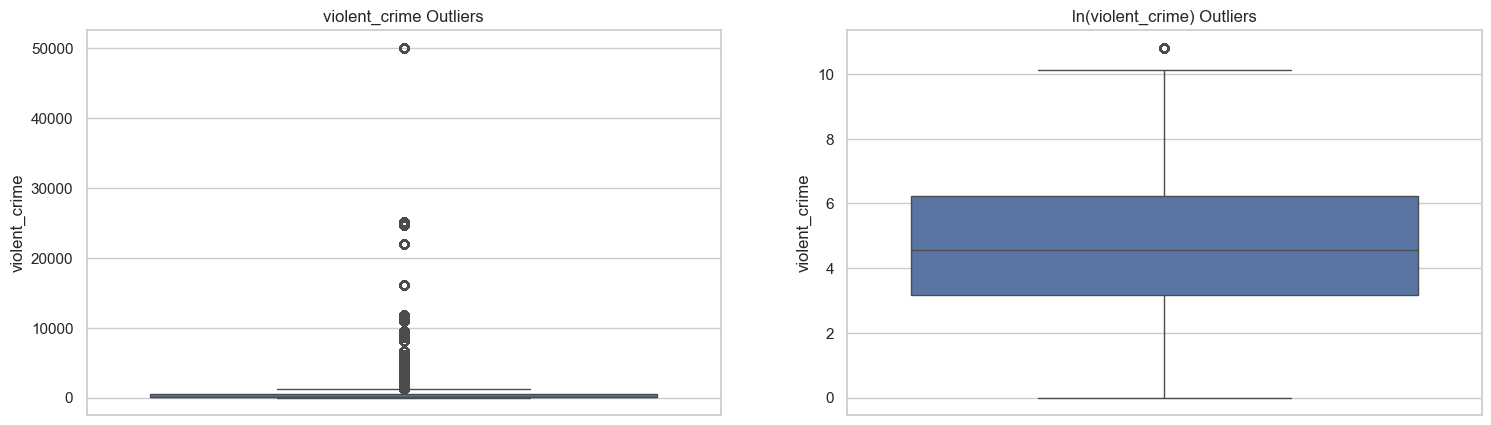

In [1124]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['violent_crime'], ax=axes[0]).set_title('violent_crime Outliers')
sns.boxplot(y=np.log1p(realtor_data['violent_crime']), ax=axes[1]).set_title('ln(violent_crime) Outliers')
plt.show()

In [1127]:
realtor_data['violent_crime'] = winsorize_col(realtor_data['violent_crime'])

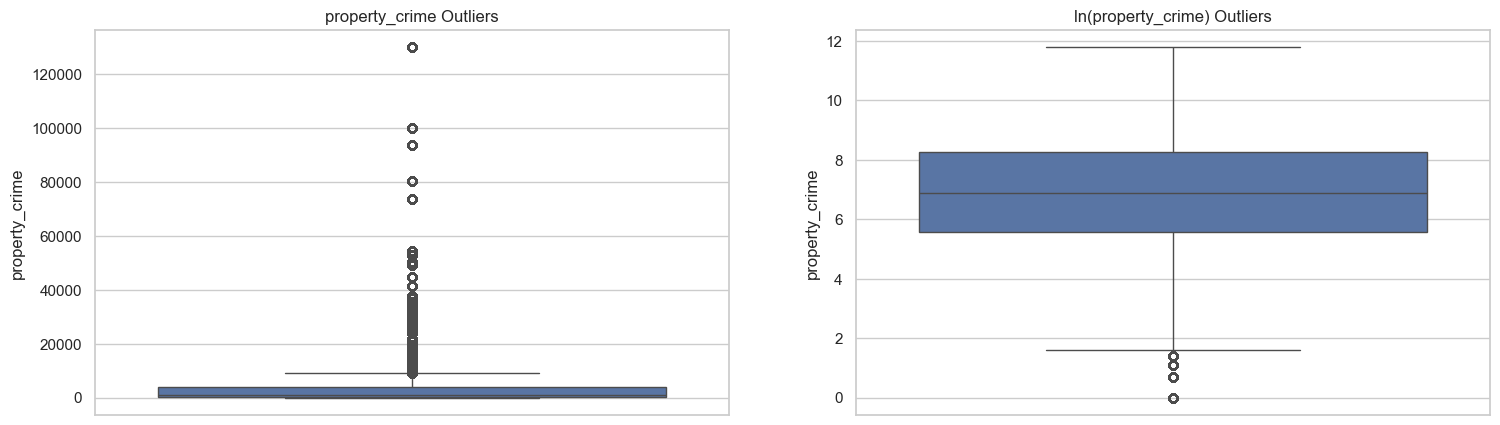

In [1129]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['property_crime'], ax=axes[0]).set_title('property_crime Outliers')
sns.boxplot(y=np.log1p(realtor_data['property_crime']), ax=axes[1]).set_title('ln(property_crime) Outliers')
plt.show()

In [1132]:
realtor_data['property_crime'] = winsorize_col(realtor_data['property_crime'])
realtor_data['total_crime'] = realtor_data['property_crime'] + realtor_data['violent_crime']
realtor_data['crime_rate'] = (realtor_data['total_crime']/realtor_data['population']) * 1_000

In [1135]:
num_cols = realtor_data.select_dtypes(include=['float64', 'int64']).columns
num_cols = [i for i in num_cols if i not in ['bed', 'bath', 'property_tax']]
skewed_feats = realtor_data[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
# high_skew = skewed_feats[skewed_feats >= 1.0].index
skewed_feats
# realtor_data[high_skew] = np.log1p(realtor_data[high_skew])

crime_rate              192.678206
distance_to_uni          84.092752
nearest_zip_distance     29.219394
density                   8.805305
median_zip_price          7.626447
acre_lot                  5.981318
violent_crime             4.977066
total_crime               3.930259
water_area                3.762964
property_crime            3.669465
price                     3.486662
inventory_count           3.396611
land_area                 3.304882
population                0.878140
closest_uni_lat          -0.052704
latitude                 -0.054629
rank                     -0.068776
closest_uni_obereg       -0.075446
longitude                -0.894078
closest_uni_lon          -0.895062
dtype: float64

Cleaned summary stats

In [1138]:
summary_stats = realtor_data.describe().T
summary_stats['std'] = summary_stats['std'].apply(lambda x: f"{x:.6f}")
summary_stats['max'] = summary_stats['max'].apply(lambda x: f"{x:.1f}")
display(summary_stats)

,count,mean,min,25%,50%,75%,max,std
price,2200928.0,482077.255385,15000.0,169900.0,328000.0,550000.0,3900000.0,583677.513932
bed,2200928.0,3.225658,1.0,3.0,3.0,4.0,35.0,1.128150
bath,2200928.0,2.432646,1.0,2.0,2.0,3.0,49.0,1.100958
acre_lot,2200928.0,2.795385,0.02,0.15,0.25,0.77,81.9,10.650028
house_size,2200928.0,1960.065506,630.0,1385.0,1767.0,2280.0,5951.0,914.852095
prev_sold_date,2200928,2016-06-28 23:43:29.206042112,1814-04-06 00:06:21.572612096,2015-04-14 00:00:00,2021-08-16 00:00:00,2022-01-25 00:00:00,.1f,nan
land_area,2200928.0,72.78764,0.739,10.09,30.622,86.001,716.1,113.743981
water_area,2200928.0,2.246296,0.0,0.063,0.433,1.849,30.7,4.877454
latitude,2200928.0,36.750704,19.065548,33.011304,37.144971,40.87024,71.3,5.541792
longitude,2200928.0,-92.259891,-164.654295,-98.487889,-87.59839,-80.587633,-67.0,15.908530


### I.iii Perform an exploratory data analysis

#### Univariate Analysis

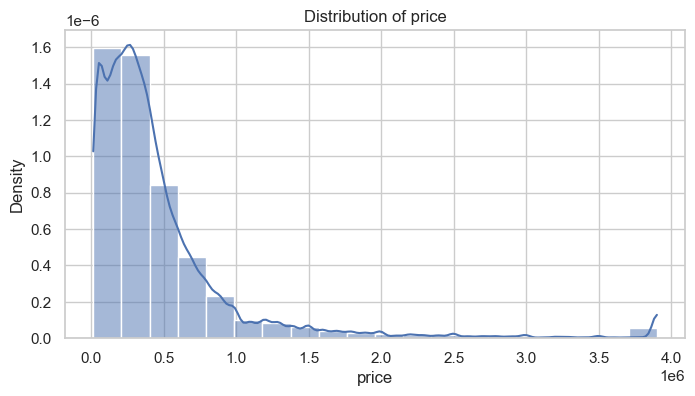

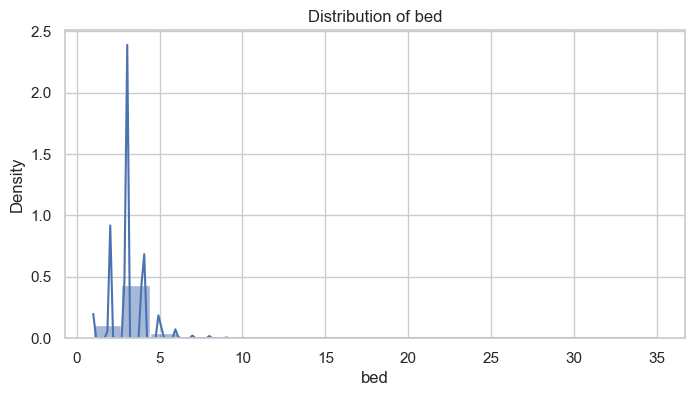

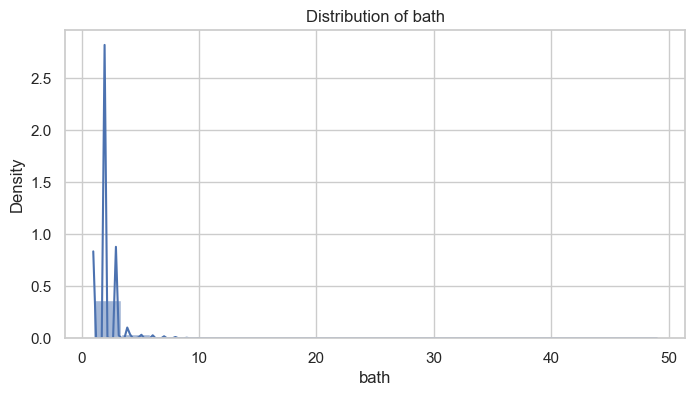

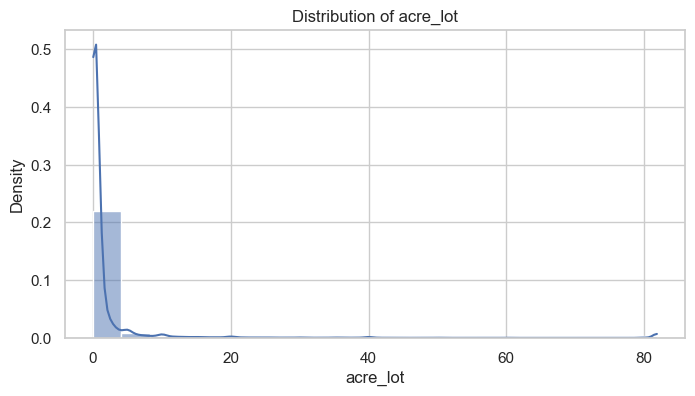

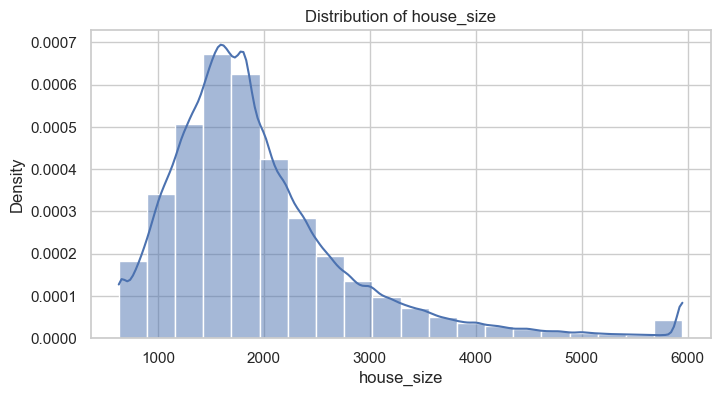

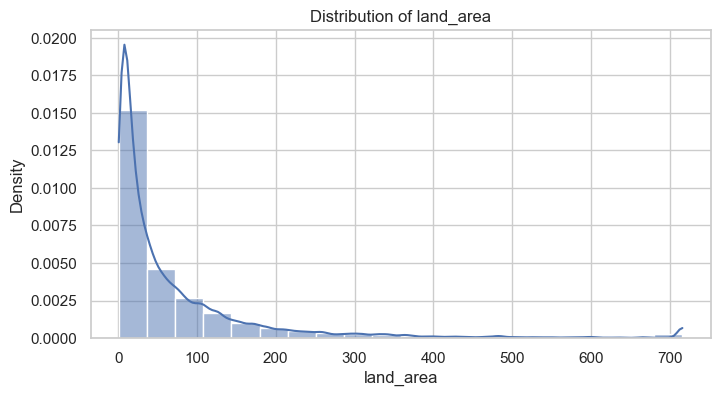

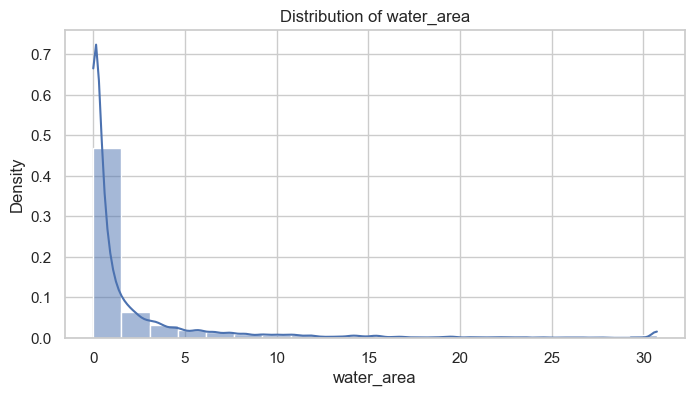

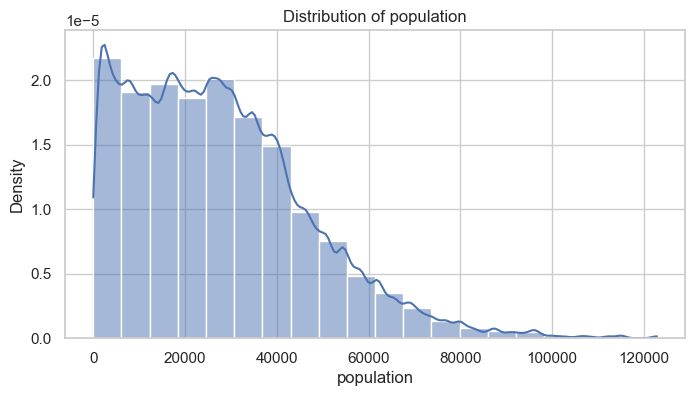

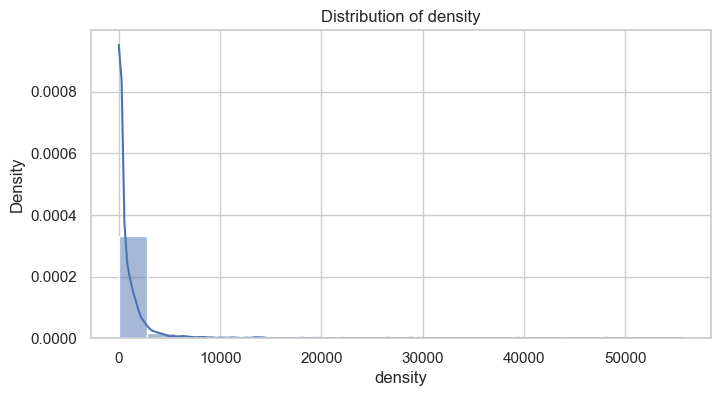

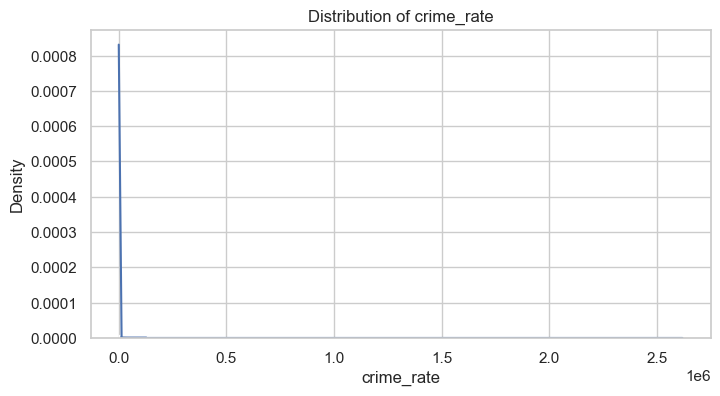

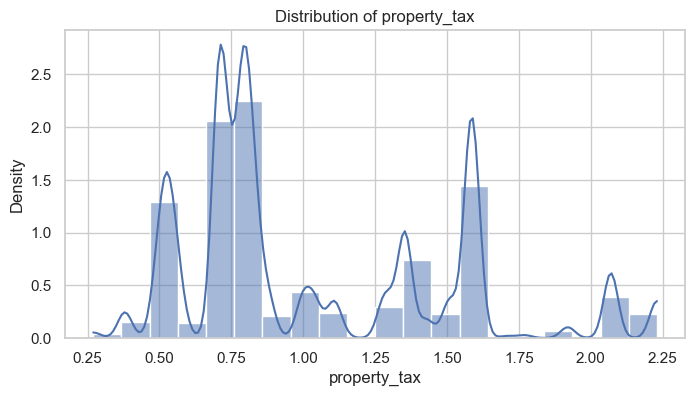

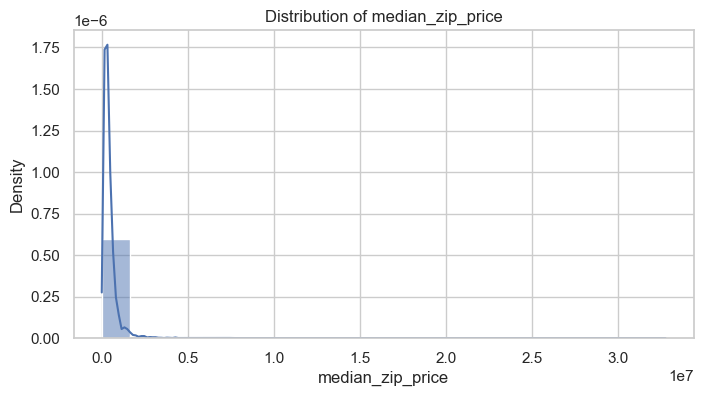

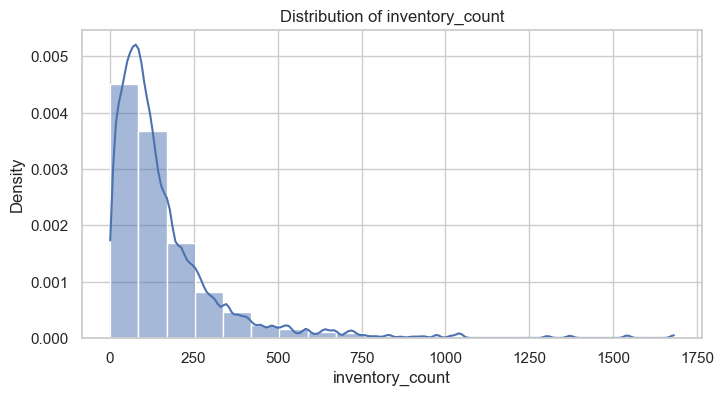

In [1142]:
numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size', 'land_area', 
                'water_area', 'population', 'density', 'crime_rate', 'property_tax', 
                'median_zip_price', 'inventory_count']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(realtor_data[col], kde=True, stat='density', bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

Distributions of the numeric features

In [1144]:
realtor_data_copy = realtor_data.copy()

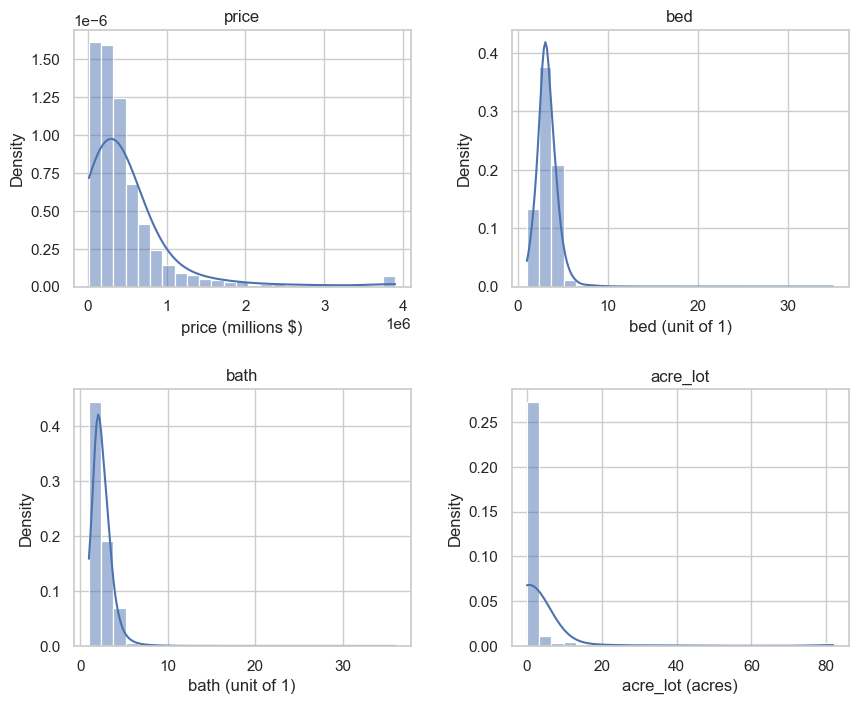

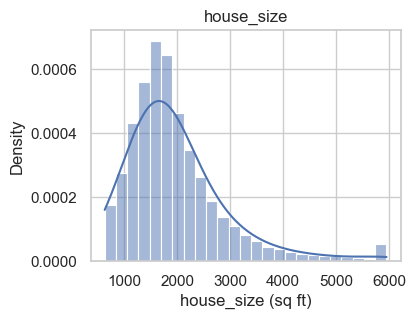

In [1145]:
numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
sampled_data = realtor_data.sample(100000, random_state=42)  # Sample 100K rows

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for ax, col in zip(axes.flatten(), numeric_cols[:4]):
    sns.histplot(data=sampled_data, x=col, kde=True, stat="density", kde_kws={"bw_adjust": 5}, bins=25, ax=ax)
    ax.set_title(col)
    if col in ['bed', 'bath']:
        ax.set_xlabel(f'{col} (unit of 1)')
    elif col == 'price':
        ax.set_xlabel(f'{col} (millions $)')
    else:
        ax.set_xlabel(f'{col} (acres)')

plt.figure(figsize=(4, 3))
sns.histplot(data=sampled_data, x=numeric_cols[4], kde=True, stat="density", kde_kws={"bw_adjust": 5}, bins=25)
plt.title(numeric_cols[4])
plt.xlabel(f'{numeric_cols[4]} (sq ft)')
plt.show()

Since the histograms of `price`, `acre_lot`, and `house_size` show extreme right-skewness, we will apply a log transformation to spread out the lower values.

In [1149]:
RE_data = realtor_data

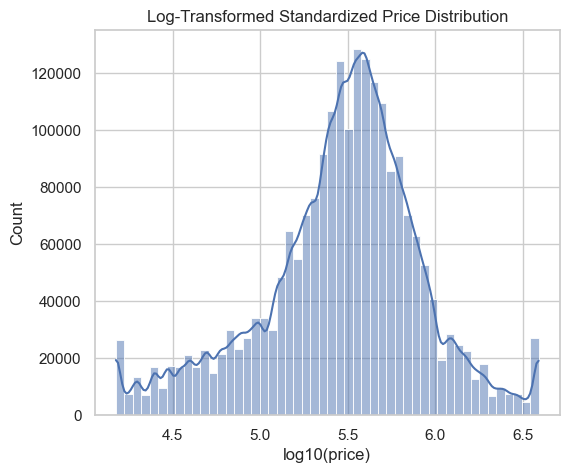

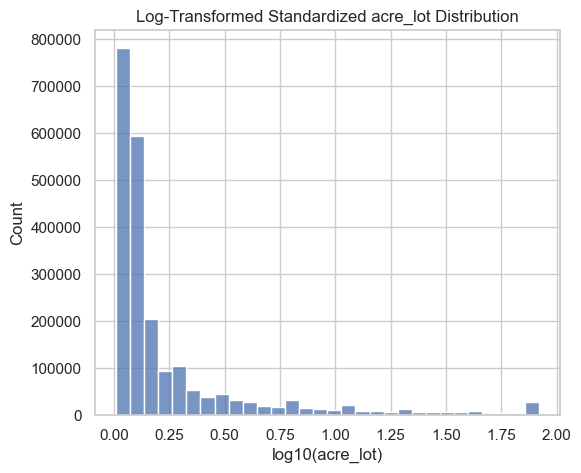

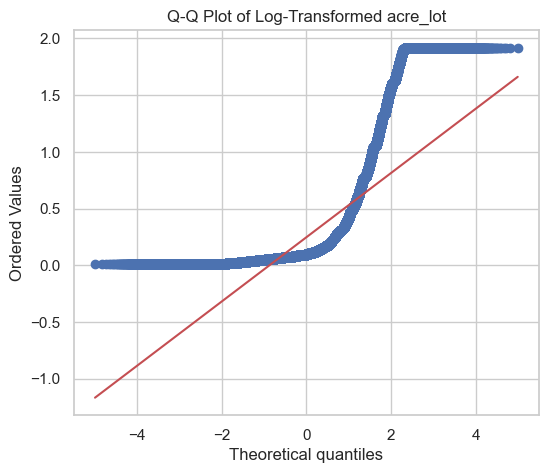

In [1151]:
# Price
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data, x=np.log10(realtor_data['price'] + 1), kde=True, bins=50, ax=ax)
ax.set_title("Log-Transformed Standardized Price Distribution")
ax.set_xlabel("log10(price)")
plt.show()

# acre_lot
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data, x=np.log10(realtor_data['acre_lot'] + 1), kde=False, bins=30, ax=ax)
ax.set_title("Log-Transformed Standardized acre_lot Distribution")
ax.set_xlabel("log10(acre_lot)")
plt.show()

# Q-Q plot
fig, ax = plt.subplots(figsize=(6, 5))
stats.probplot(np.log10(realtor_data['acre_lot'] + 1), dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Log-Transformed acre_lot")
plt.show()

Code below don't work

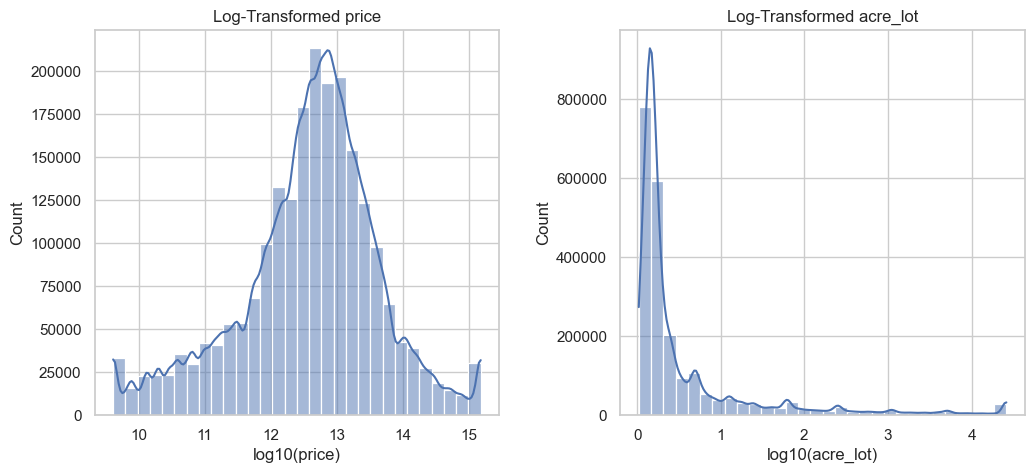

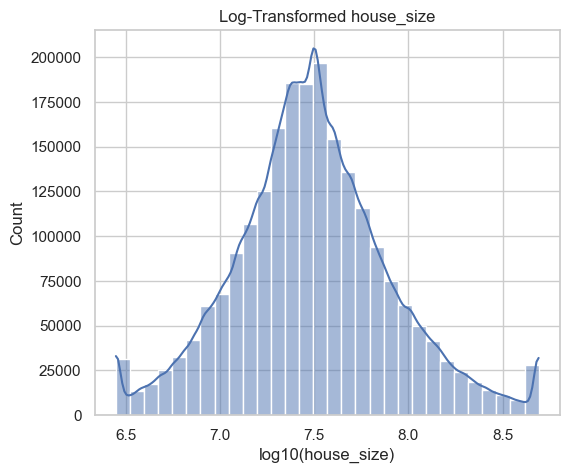

In [1153]:
# Plotting log-transformed standardized values for 'price' and 'acre_lot'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for ax, col in zip(axes.flatten(), ['price', 'acre_lot']):
    # Plot log-transformed standardized values
    sns.histplot(data=realtor_data_copy, x=np.log1p(realtor_data_copy[col]), kde=True, bins=30, ax=ax)
    ax.set_title(f"Log-Transformed {col}")
    ax.set_xlabel(f"log10({col})")

plt.show()

# Plotting for 'house_size'
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data_copy, x=np.log1p(realtor_data_copy['house_size']), kde=True, bins=30)
ax.set_title("Log-Transformed house_size")
ax.set_xlabel("log10(house_size)")
plt.show()

In [1155]:
# Ensure only numeric columns are considered
numeric_cols = realtor_data.select_dtypes(include=['number']).columns

# Compute skewness only for numeric columns
skewed_cols = numeric_cols[realtor_data[numeric_cols].skew() > 2].tolist()

# Apply log transformation for highly skewed columns
realtor_data[skewed_cols] = realtor_data[skewed_cols].apply(lambda x: np.log1p(x))

print(f"Log-transformed columns: {skewed_cols}")

Log-transformed columns: ['price', 'bed', 'bath', 'acre_lot', 'land_area', 'water_area', 'density', 'violent_crime', 'property_crime', 'distance_to_uni', 'median_zip_price', 'inventory_count', 'nearest_zip_distance', 'total_crime', 'crime_rate']


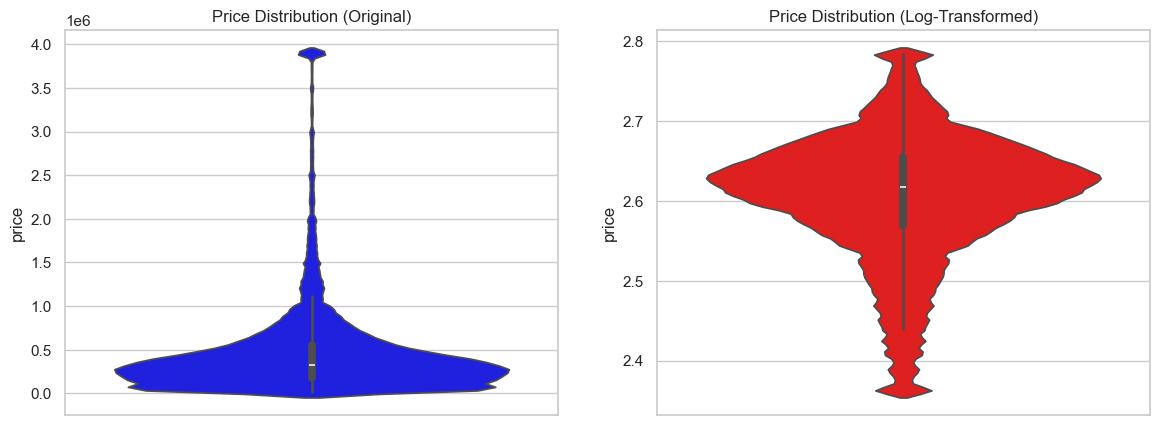

In [1164]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before log transformation
sns.violinplot(y=realtor_data_copy['price'], ax=axes[0], color='blue')
axes[0].set_title('Price Distribution (Original)')

# After log transformation
sns.violinplot(y=np.log1p(realtor_data['price']), ax=axes[1], color='red')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.show()

## Finding Outliers

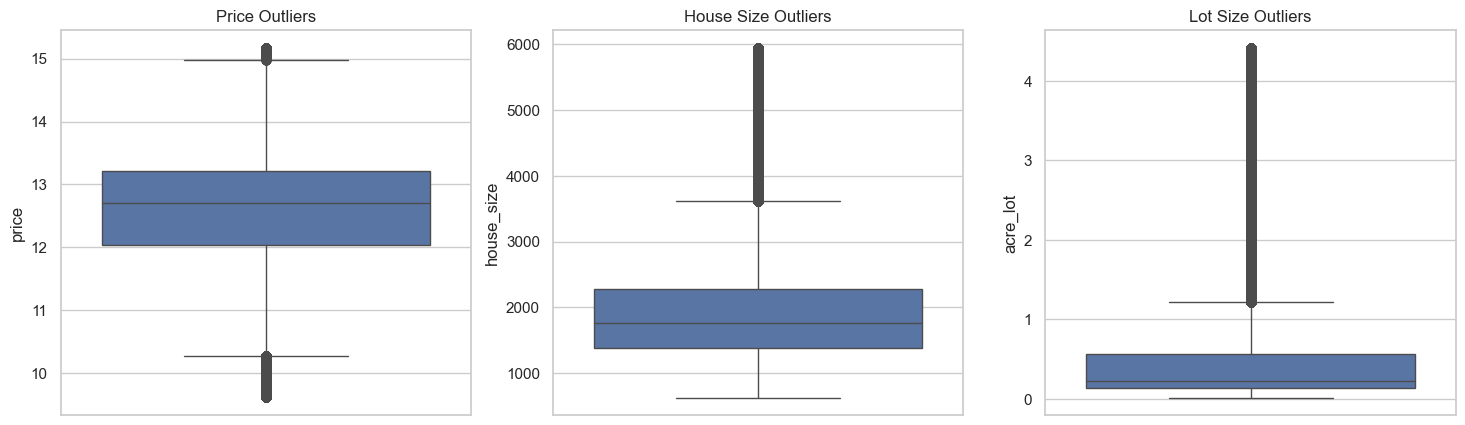

In [1160]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=realtor_data['price'], ax=axes[0]).set_title('Price Outliers')
sns.boxplot(y=realtor_data['house_size'], ax=axes[1]).set_title('House Size Outliers')
sns.boxplot(y=realtor_data['acre_lot'], ax=axes[2]).set_title('Lot Size Outliers')

plt.show()

## Heatmap

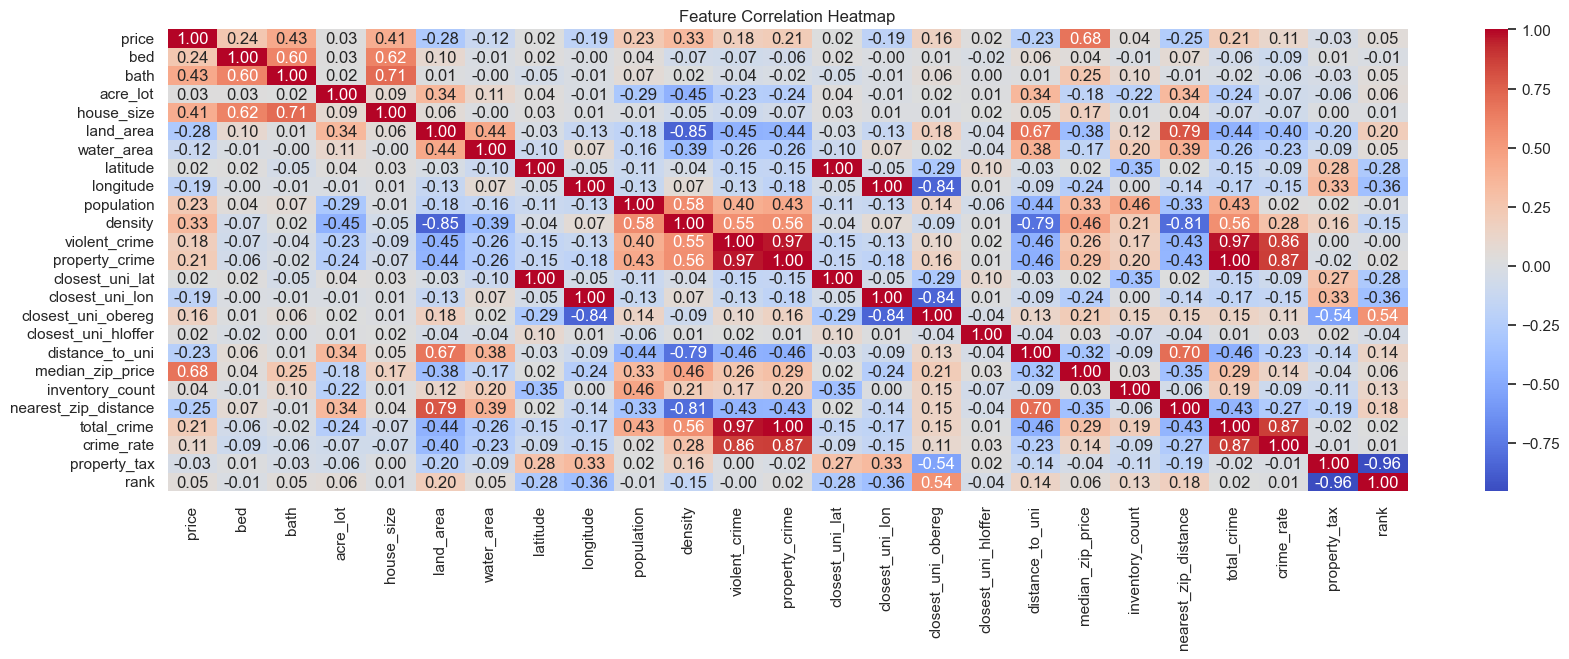

In [1162]:
numeric_data = realtor_data.select_dtypes(include=['number'])
plt.figure(figsize=(20, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

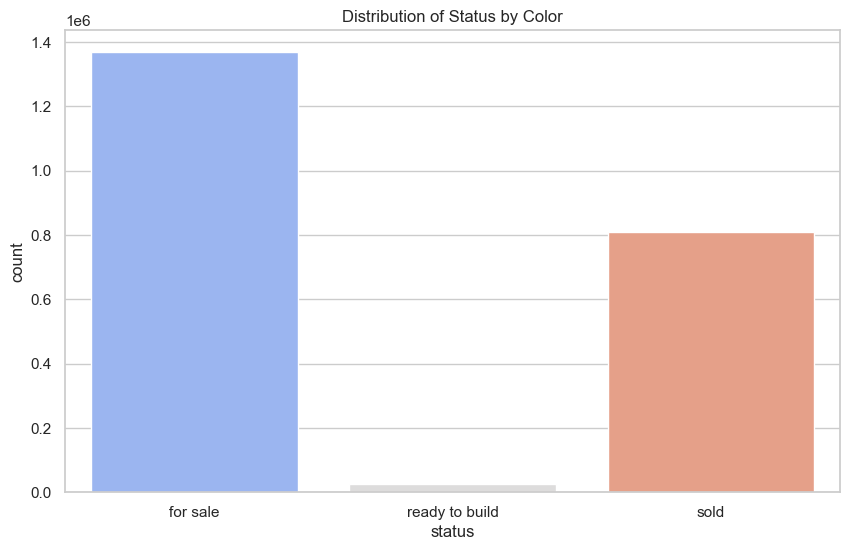

In [1166]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='status', data=realtor_data, hue='status', palette='coolwarm')
plt.title("Distribution of Status by Color")
plt.show()


In [1168]:
RE = realtor_data

In [1170]:
outlier_list = ['price','bed','house_size']
max = 3
for i in outlier_list:
    z_scores = np.abs((RE_data[i] - RE_data[i].mean()) / RE_data[i].std())
    RE_data = RE_data[z_scores <= max]

## Avg house size by state

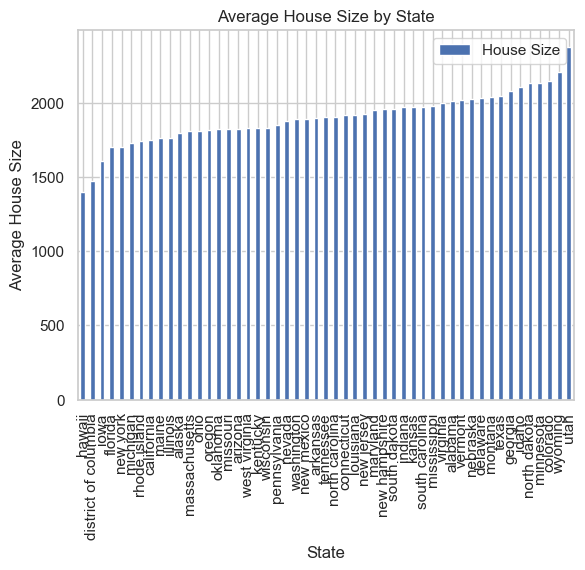

In [1173]:
avg_house_size = RE_data[['state','house_size']]\
                .groupby('state')\
                .mean()\
                .sort_values('house_size')\
                .rename(columns={'house_size':'House Size'})
avg_house_size.index.name = 'State'

avg_house_size.plot(kind='bar');
plt.title('Average House Size by State');
plt.ylabel('Average House Size');

## Price range frequency

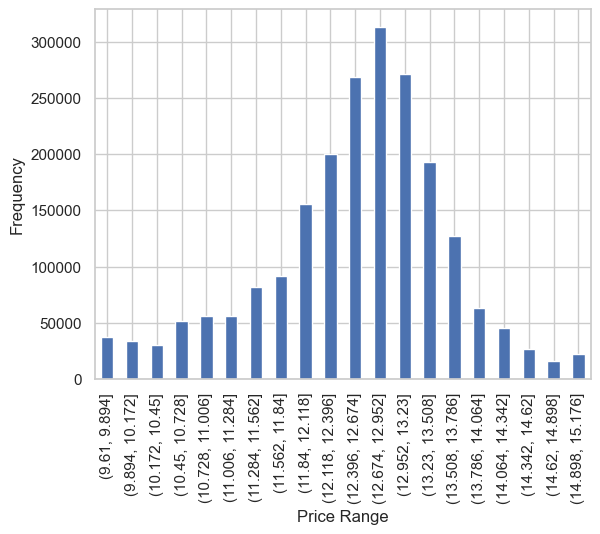

In [1176]:
num_bins = 20
price_range = (0,100)

hist_price = pd.cut(RE_data['price'], bins=num_bins)

dist_houseprice = hist_price.value_counts().sort_index().round(2).plot(kind='bar');

plt.xlabel('Price Range')
plt.ylabel('Frequency')

dist_houseprice;

## Price distribution on bedroom

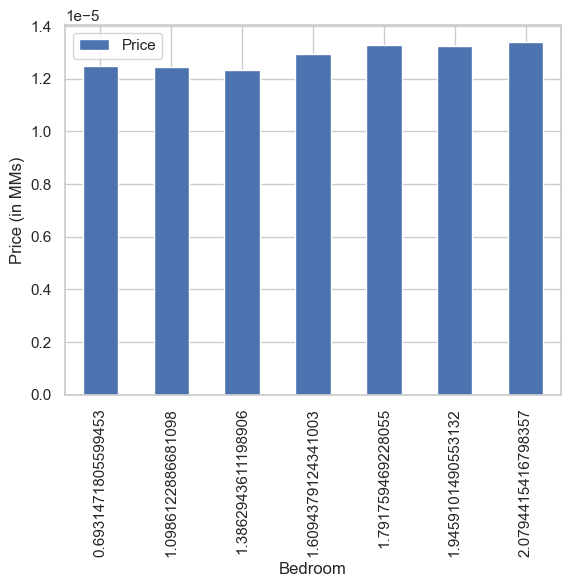

In [1179]:
def as_millions(value):
    return value/1_000_000


avg_price_bdr = RE_data[['price','bed']]\
                .groupby('bed')\
                .mean()\
                .rename(columns={'price':'Price'})\
                .apply(as_millions)
    
avg_price_bdr.index.name = "Bedroom"

avg_price_bdr

avg_price_bdr.plot(kind='bar')
plt.ylabel('Price (in MMs)');

## Avg price of State

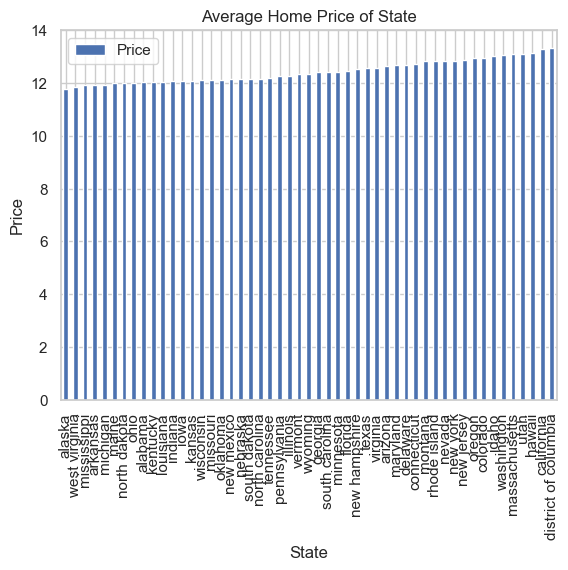

In [1182]:
avg_price_state = RE_data[['state','price']]\
                .groupby('state')\
                .mean()\
                .sort_values('price')\
                .rename(columns={'price':'Price'})
avg_price_state.index.name = 'State'

avg_price_state.plot(kind='bar')
plt.ylabel('Price')
plt.title('Average Home Price of State');

In [1184]:
## Highest Average Home Price accross citys

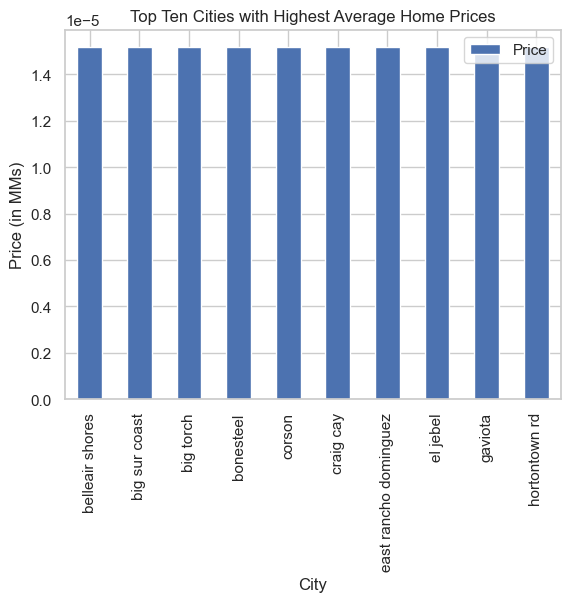

In [1186]:
avg_price_city = RE_data[['city','price']]\
                .groupby('city')\
                .mean()\
                .nlargest(10,'price')\
                .rename(columns={'price':'Price'})
avg_price_city.index.name = 'City'

avg_price_city['Price'] = avg_price_city['Price'].apply(as_millions) 
                
avg_price_city

avg_price_city.plot(kind='bar');
plt.ylabel('Price (in MMs)');
plt.title('Top Ten Cities with Highest Average Home Prices');

# Clustering to group the homes

## K-mean

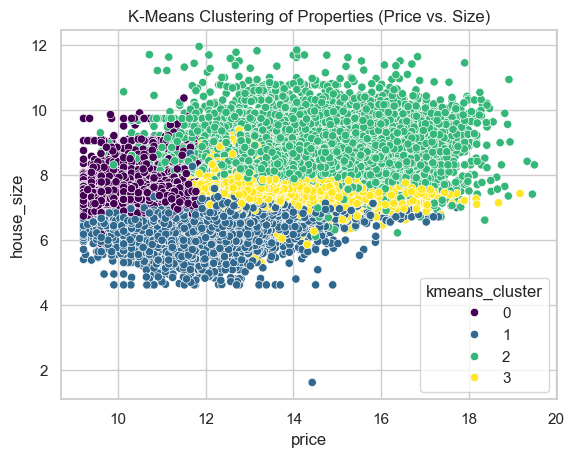

In [913]:
features = ['price', 'bed', 'bath', 'house_size']
realtor_cluster = realtor_data[features].dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(realtor_cluster)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
realtor_data['kmeans_cluster'] = kmeans.fit_predict(scaled_data)
sns.scatterplot(x=realtor_data['price'], y=realtor_data['house_size'], hue=realtor_data['kmeans_cluster'], palette='viridis')
plt.title("K-Means Clustering of Properties (Price vs. Size)")
plt.show()

This scatter plot represents K-Means clustering of properties based on price (x-axis) and house size (y-axis), using four distinct clusters. The dataset consists of over 2 million property listings, grouped into clusters based on similarity in price and house size.  

1. Cluster Analysis  
Cluster 0 (Purple)  
- Represents mid-range price and mid-to-large house sizes.  
- Likely includes the majority of standard single-family homes in the dataset.  
- Appears to span a wide range of house sizes, suggesting some variability in pricing.  

Cluster 1 (Blue)  
- Composed primarily of higher-priced homes.  
- Houses in this cluster vary in size, but the majority are mid-sized to large homes.  
- This may represent a luxury housing segment in the dataset.  

Cluster 2 (Green)  
- Represents moderate-priced homes with mid-sized houses.  
- The cluster is densely populated, indicating that most properties fall into this range.  
- Shows some overlap with Cluster 0 (Purple) but with a distinct pricing trend.  

Cluster 3 (Yellow)  
- Two distinct groups:  
  - Extremely low-priced properties, possibly undeveloped land, small apartments, or foreclosures.  
  - Small-sized houses with varying prices, indicating a mix of studio apartments, budget-friendly homes, or rental properties.  
- The horizontal concentration at house_size ≈ 0 suggests that this cluster may include non-residential properties such as land plots, garages, or commercial spaces.  

2. Outliers & Anomalies  
- Luxury Home Outliers:  
  - The high-priced outliers (in purple and blue) may represent multi-million-dollar homes or mansions.  
- Small Size, High Price Properties:  
  - Some very small houses appear in higher price brackets, which may be due to prime location, unique property features, or real estate market trends.  
- Flat Band at House Size ≈ 0:  
  - This could indicate:  
    - Vacant land listings  
    - Misclassified properties  
    - Parking spaces or non-traditional housing units  

3. Market Segmentation Insights  
This clustering suggests distinct property segments, which may represent different buyer types:  

- Budget Buyers (Yellow Cluster) – Likely targeting small, affordable properties, such as starter homes, apartments, or land investments.  
- Mid-Range Buyers (Purple & Green Clusters) – Representing the standard housing market, including suburban homes and multi-bedroom residences.  
- Luxury Buyers (Blue Cluster) – These properties cater to high-end buyers, featuring large houses, exclusive amenities, or high-demand locations.  

4. Price vs. House Size Relationship  
- A positive correlation between house size and price is evident in most clusters, meaning larger houses generally cost more.  
- However, some small homes still command high prices, possibly due to:  
  - Prime location (urban areas, waterfront properties, high-demand neighborhoods)  
  - Luxury features (high-end apartments, custom-built small homes, or penthouses)  
  - Real estate market fluctuations  

5. Potential Next Steps for Analysis  
- Refine Clustering with Additional Features  
  - Incorporate location (latitude, longitude), crime rate, school ratings, or property tax rates to improve segmentation.  
- Investigate Outliers  
  - Check if extreme values (high-price, small-size properties) are due to market trends or data errors.  
- Apply DBSCAN for Density-Based Clustering  
  - K-Means assumes all clusters are spherical, but real estate markets may have irregular pricing trends that DBSCAN could better capture.  
- Geospatial Visualization  
  - Mapping clusters using Geopandas or Folium could reveal regional price patterns.  
 



## DBSCAN

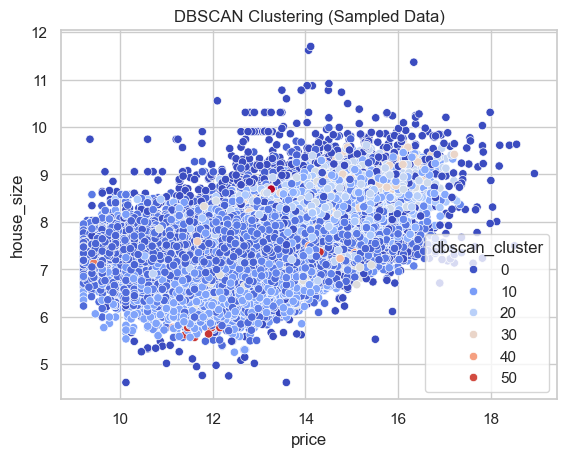

In [915]:
sampled_data = realtor_data.sample(frac=0.1, random_state=42)
scaled_sampled_data = scaler.transform(sampled_data[features])
dbscan = DBSCAN(eps=0.5, min_samples=5)
sampled_data['dbscan_cluster'] = dbscan.fit_predict(scaled_sampled_data)
sns.scatterplot(x=sampled_data['price'], y=sampled_data['house_size'], hue=sampled_data['dbscan_cluster'], palette='coolwarm')
plt.title("DBSCAN Clustering (Sampled Data)")
plt.show()

This scatter plot represents Density-Based Spatial Clustering of Applications with Noise (DBSCAN) applied to properties based on price (x-axis) and house size (y-axis). Unlike K-Means, DBSCAN does not assume spherical clusters and can detect varying densities, making it suitable for real estate market segmentation.  

1. Cluster Analysis  
DBSCAN assigns cluster labels based on density rather than a fixed number of clusters. Key observations from the clustering results:  

Core Clusters (Blue Shades)  
- Represent densely populated price and house size groups.  
- Majority of properties fall into a single dominant cluster (label 0).  
- Indicate mainstream housing markets with typical pricing trends.  

Sparse Clusters (Light Blue to Red Shades)  
- Less dense regions in the dataset.  
- Likely represent less common housing markets or areas with unique pricing patterns.  

Outliers (Dark Red Points)  
- DBSCAN identifies outliers explicitly, which are not assigned to any cluster.  
- These could be:  
  - Luxury properties with exceptionally high prices.  
  - Undervalued properties based on their features.  
  - Potential data errors or anomalies in the dataset.  

2. Outliers & Anomalies  
- Red-colored points represent outliers detected by DBSCAN.  
- These properties do not belong to any cluster because they do not meet the minimum density criteria.  
- The concentration of outliers in low-price, small-house areas suggests possible foreclosures, undeveloped lots, or mispriced properties.  

3. Market Segmentation Insights  
Unlike K-Means, DBSCAN provides a more flexible segmentation of the real estate market:  

- Densely Populated Clusters (Blue Regions) → Representing the standard housing market, including typical residential homes.  
- Sparse Clusters (Lighter Blue to Red Shades) → Representing less frequent property types, such as premium-priced properties or underdeveloped plots.  
- Outliers (Red Points) → Properties that do not follow normal market trends; could be luxury homes, distressed properties, or investment opportunities.  

4. Price vs. House Size Relationship  
- A strong core cluster suggests a typical price-size relationship where price increases with house size.  
- Outliers suggest there are exceptions, where:  
  - Some small properties have high prices, possibly due to location or high demand.  
  - Some large properties have low prices, which could indicate older homes or properties in less desirable areas.  

5. Potential Next Steps for Analysis  
- Optimize DBSCAN Parameters  
  - The choice of `eps=0.5, min_samples=5` may affect clustering results.  
  - Experimenting with different values can improve outlier detection.  
- Incorporate Geospatial Analysis  
  - Adding latitude and longitude can improve location-based clustering.  
  - Use geospatial DBSCAN (HDBSCAN) for better clustering in real estate markets.  
- Compare DBSCAN with Other Clustering Models  
  - K-Means → Assumes spherical clusters, better for structured markets.  
  - Gaussian Mixture Models (GMM) → Useful for overlapping price distributions.  

6. Conclusion  
DBSCAN provides a density-based clustering approach that is particularly useful in identifying outliers and irregular market trends. Unlike K-Means, it does not assume a fixed number of clusters and can adapt to complex property distributions.  



## GMM

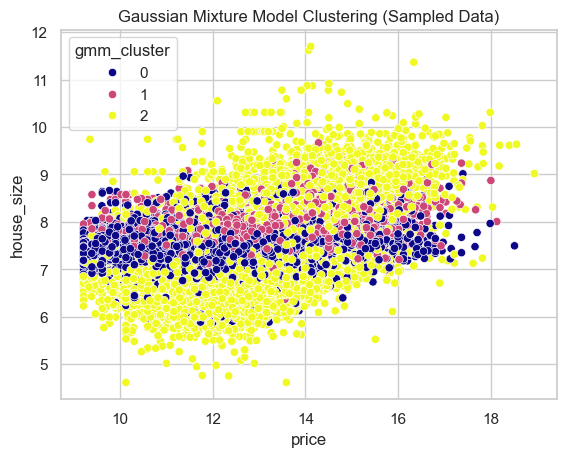

In [919]:
sampled_data = realtor_data.sample(frac=0.1, random_state=42) 
scaled_sampled_data = scaler.transform(sampled_data[features])
gmm = GaussianMixture(n_components=3, random_state=42)
sampled_data['gmm_cluster'] = gmm.fit_predict(scaled_sampled_data)
sns.scatterplot(x=sampled_data['price'], y=sampled_data['house_size'], hue=sampled_data['gmm_cluster'], palette='plasma')
plt.title("Gaussian Mixture Model Clustering (Sampled Data)")
plt.show()

This scatter plot represents Gaussian Mixture Model (GMM) clustering applied to properties based on price (x-axis) and house size (y-axis). Unlike K-Means and DBSCAN, GMM is a probabilistic model that assumes each cluster follows a Gaussian distribution, allowing for overlapping clusters and soft clustering assignments.  

1. Cluster Analysis  
GMM assigns each property to a cluster with a probability distribution, meaning some points belong to multiple clusters with varying confidence levels.  

Cluster 0 (Dark Blue)  
- Represents densely populated areas of the dataset.  
- Likely includes the mainstream housing market, where price and house size follow standard distribution patterns.  
- Covers a wide range of house sizes, but generally follows an increasing price trend.  

Cluster 1 (Pink)  
- Represents a transitional group between the core market and outliers.  
- Properties here overlap with both high-density and low-density clusters.  
- Likely includes mid-priced homes that don’t fit neatly into one extreme category.  

Cluster 2 (Yellow)  
- Represents high variance properties.  
- Includes many small homes with both low and high prices, suggesting different market segments (e.g., affordable housing vs. high-demand small units).  
- Some outlier properties with larger sizes exist in this cluster, possibly due to unique market conditions.  

2. Outliers & Anomalies  
- Overlapping clusters indicate mixed pricing behaviors.  
  - Some smaller homes appear expensive, possibly due to location, high demand, or luxury features.  
  - Some larger homes remain relatively low-priced, potentially due to location disadvantages, age, or condition of the property.  
- Yellow cluster contains a broad range of points, indicating high uncertainty in pricing for those homes.  

3. Market Segmentation Insights  
Compared to K-Means and DBSCAN, GMM provides a probabilistic perspective on clustering, identifying soft clusters where properties may belong to multiple segments.  

- Core Market (Dark Blue - Cluster 0) → Represents stable pricing trends where price and house size follow expected relationships.  
- Transition Market (Pink - Cluster 1) → Represents properties that overlap between standard and outlier markets, indicating market fluctuations.  
- High Variance Market (Yellow - Cluster 2) → Properties with inconsistent pricing behaviors, likely influenced by location, demand, or unique property characteristics.  

4. Price vs. House Size Relationship  
- The Gaussian-based clusters suggest continuous pricing variation rather than discrete categories.  
- The presence of outliers in the yellow cluster indicates that traditional price-size relationships may not apply uniformly.  
- Some houses with similar sizes fall into different price clusters, suggesting the importance of other factors (e.g., location, amenities).  

5. Potential Next Steps for Analysis  
- Validate GMM with Additional Features  
  - Incorporate location-based variables (latitude, longitude) to see if clusters align with geographic areas.  
  - Add crime rates, school ratings, or property tax data to refine segmentation.  
- Compare GMM with K-Means & DBSCAN  
  - K-Means → Good for well-separated clusters, but may not handle overlapping categories.  
  - DBSCAN → Best for detecting outliers, but assumes dense clusters.  
  - GMM → Provides soft clustering, useful for housing markets where properties don’t fit into strict categories.  
- Investigate High Variance Properties  
  - Why are some small homes expensive?  
  - Why are some large homes priced lower?  
  - Are certain regions more prone to price fluctuations?  

6. Conclusion  
Gaussian Mixture Model (GMM) clustering provides a flexible, probabilistic approach to real estate market segmentation. Unlike K-Means and DBSCAN, it allows for overlapping clusters, which more accurately reflects real-world housing trends where properties do not always belong to a single category.  


## PCA

Use full_model to see if weights are statistically significant for linear regression

In [316]:
scaler = StandardScaler()
scaler.fit_transform(realtor_data_copy[['price']])
standardized_prediction = -0.3
original_price = scaler.inverse_transform([[standardized_prediction]])[0][0]
original_price

-0.3

In [ ]:
# ---- FEATURE ENGINEERING ----
realtor_data["price_per_sqft"] = realtor_data["price"] / realtor_data["house_size"]
realtor_data["crime_index"] = realtor_data["violent_crime"] + realtor_data["property_crime"]
realtor_data["density_score"] = realtor_data["density"]  # High density → Starter homes, Low density → Luxury
realtor_data["land_water_ratio"] = realtor_data["land_area"] / (realtor_data["water_area"] + 1)  # Avoid division by zero

# Selecting features for clustering
features = [
    "price", "house_size", "bed", "bath", "acre_lot", "price_per_sqft",
     "density_score", "property_tax", "median_zip_price"]

# Drop rows with missing values
realtor_data = realtor_data.dropna(subset=features)

# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(realtor_data[features])

In [ ]:
def find_optimal_k(data, sample_size=5000):
    inertia = []
    silhouette_scores = []
    K_range = range(2, 10)  # Testing K from 2 to 9

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        inertia.append(kmeans.inertia_)

        # Subsample Silhouette Score Calculation for Large Datasets
        if len(data) > sample_size:
            indices = np.random.choice(len(data), sample_size, replace=False)
            sample_data = data[indices]
            sample_labels = labels[indices]
            silhouette_scores.append(silhouette_score(sample_data, sample_labels))
        else:
            silhouette_scores.append(silhouette_score(data, labels))

    # Plot Elbow Method
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, inertia, marker="o")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow Method for Optimal K")

    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, marker="o", color="red")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score Analysis")
    plt.show()

In [ ]:
# ---- APPLY K-MEANS ----
optimal_k = 4  # Adjust based on the Elbow & Silhouette Score graphs
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
realtor_data["kmeans_cluster"] = kmeans.fit_predict(scaled_data)

In [ ]:
# ---- APPLY GAUSSIAN MIXTURE MODEL (GMM) ----
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
realtor_data["gmm_cluster"] = gmm.fit_predict(scaled_data)

In [ ]:
# ---- VISUALIZE CLUSTERS USING PCA ----
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
realtor_data["pca_x"] = pca_result[:, 0]
realtor_data["pca_y"] = pca_result[:, 1]

plt.figure(figsize=(15, 5))

# K-Means Clusters
plt.subplot(1, 3, 1)
sns.scatterplot(x="pca_x", y="pca_y", hue=realtor_data["kmeans_cluster"], palette="tab10", data=realtor_data)
plt.title("K-Means Clustering")

# GMM Clusters
plt.subplot(1, 3, 2)
sns.scatterplot(x="pca_x", y="pca_y", hue=realtor_data["gmm_cluster"], palette="tab10", data=realtor_data)
plt.title("Gaussian Mixture Model Clustering")

# Hierarchical Clusters (Only if it ran successfully)
if "hierarchical_cluster" in realtor_data.columns and realtor_data["hierarchical_cluster"].notna().any():
    plt.subplot(1, 3, 3)
    sns.scatterplot(x="pca_x", y="pca_y", hue=realtor_data["hierarchical_cluster"], palette="tab10", data=realtor_data)
    plt.title("Hierarchical Clustering")
else:
    print("⚠️ Skipping Hierarchical Clustering visualization due to errors.")

plt.show()

In [494]:
# ---- ANALYZE CLUSTERS TO UNDERSTAND PATTERNS ----
# Get summary stats for each cluster
cluster_summary = realtor_data.groupby("kmeans_cluster")[["price", "house_size", "crime_index", "density_score"]].mean()
print(cluster_summary)

# ---- DEFINE CLUSTER TO CATEGORY MAPPING ----
# Modify based on actual data analysis
cluster_mapping = {
    0: "Starter Home",       # Smaller, cheaper, higher density
    1: "Luxury Home",        # Expensive, large house size, low crime
    2: "Family Home",        # Mid-range price, decent size, family-friendly
    3: "Investment Property" # Possibly near universities, high tax, good ROI
}

# ---- APPLY CLASSIFICATION ----
realtor_data["house_category"] = realtor_data["kmeans_cluster"].map(cluster_mapping)


                    price  house_size  crime_index  density_score
kmeans_cluster                                                   
0               12.719325    7.161089    13.511229       6.583913
1               13.302564    7.875670    12.146639       5.909166
2               11.295781    7.419260     9.822678       4.104596
3               12.965592    7.545184     9.349811       3.325790
✅ Classification complete! Results saved in 'classified_housing_data.csv'.
       price  house_size house_category
0  12.100718    6.517671   Starter Home
1  10.126671    7.242798    Family Home
2  12.042971    6.794587   Starter Home
3  12.396697    7.264730   Starter Home
4  12.611374    7.414573   Starter Home


### Dead end not useful insight above

In [741]:
display(realtor_data.isnull().sum())

brokered_by             0
status                  0
price                   0
bed                     0
bath                    0
acre_lot                0
street                  0
city                    0
state                   0
zip_code                0
house_size              0
prev_sold_date          0
first_time              0
land_area               0
water_area              0
latitude                0
longitude               0
population              0
density                 0
violent_crime           0
property_crime          0
closest_uni_name        0
closest_uni_lat         0
closest_uni_lon         0
closest_uni_zip         0
closest_uni_obereg      0
closest_uni_hloffer     0
distance_to_uni         0
median_zip_price        0
inventory_count         0
nearest_zip             0
nearest_zip_distance    0
total_crime             0
crime_rate              0
property_tax            0
rank                    0
dtype: int64

# OLS find best combinations

In [1189]:
response = "price"

In [1191]:
drop = realtor_data.select_dtypes(exclude=["number"]).columns.tolist()

In [1193]:
drop

['brokered_by',
 'status',
 'street',
 'city',
 'state',
 'zip_code',
 'prev_sold_date',
 'first_time',
 'closest_uni_name',
 'closest_uni_zip',
 'nearest_zip']

In [1211]:
drop_2 = ['price']

In [1213]:
covariates =  realtor_data.columns.drop(drop).tolist()
covariates = [col for col in covariates if col not in drop_2]

In [1215]:
covariates

['bed',
 'bath',
 'acre_lot',
 'house_size',
 'land_area',
 'water_area',
 'latitude',
 'longitude',
 'population',
 'density',
 'violent_crime',
 'property_crime',
 'closest_uni_lat',
 'closest_uni_lon',
 'closest_uni_obereg',
 'closest_uni_hloffer',
 'distance_to_uni',
 'median_zip_price',
 'inventory_count',
 'nearest_zip_distance',
 'total_crime',
 'crime_rate',
 'property_tax',
 'rank']

## Stepwise (Not enought memory)

In [ ]:
%%time

def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10):
    """
    Performs forward and backward stepwise selection based on p-values.
    """
    selected = []
    while True:
        changed = False
        
        # Forward step
        remaining = list(set(covariates) - set(selected))
        new_pvals = pd.Series(index=remaining, dtype=float)
        for new_var in remaining:
            X_subset = sm.add_constant(X[selected + [new_var]])
            pval = sm.OLS(y, X_subset).fit().pvalues[new_var]
            new_pvals[new_var] = pval
        
        if new_pvals.min() < threshold_in:
            best_new_var = new_pvals.idxmin()
            selected.append(best_new_var)
            changed = True

        # Backward step
        X_subset = sm.add_constant(X[selected])
        pvals = sm.OLS(y, X_subset).fit().pvalues.iloc[1:]  # Exclude intercept
        
        worst_pval = pvals.max()
        if worst_pval > threshold_out:
            worst_var = pvals.idxmax()
            selected.remove(worst_var)
            changed = True

        if not changed:
            break

    return selected


X = realtor_data[covariates]
X = X.fillna(X.mean()) 
y = realtor_data[response]
selected_features = stepwise_selection(X, y)
X_final = sm.add_constant(X[selected_features])
model = sm.OLS(y, X_final).fit()

# Print results
print(f"Selected Features: {selected_features}")
print(model.summary())

In [843]:
realtor_data.columns.tolist()

['brokered_by',
 'status',
 'price',
 'bed',
 'bath',
 'acre_lot',
 'street',
 'city',
 'state',
 'zip_code',
 'house_size',
 'prev_sold_date',
 'first_time',
 'land_area',
 'water_area',
 'latitude',
 'longitude',
 'population',
 'density',
 'violent_crime',
 'property_crime',
 'closest_uni_name',
 'closest_uni_lat',
 'closest_uni_lon',
 'closest_uni_zip',
 'closest_uni_obereg',
 'closest_uni_hloffer',
 'distance_to_uni',
 'median_zip_price',
 'inventory_count',
 'nearest_zip',
 'nearest_zip_distance',
 'total_crime',
 'crime_rate',
 'property_tax',
 'rank']

## AIC (Not enought memory)

In [ ]:
import statsmodels.formula.api as smf
from tqdm import tqdm
from joblib import Parallel, delayed
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
import numpy as np

def criterion(formula, df):
    """
    Calculate the BIC for a given regression model formula and dataframe.
    """
    y, X = dmatrices(formula, df, return_type='dataframe')
    
    # Use scikit-learn's LinearRegression (much more memory-efficient)
    model = LinearRegression().fit(X, y)
    
    # Compute BIC manually
    n = X.shape[0]  # Number of observations
    k = X.shape[1]  # Number of parameters
    rss = np.sum((y - model.predict(X)) ** 2)  # Residual sum of squares
    bic = n * np.log(rss / n) + k * np.log(n)

    return aic


# Parallelized function to compute BIC for feature removal
def compute_criterion(df, already_selected_columns, criterion, column, response):
    """
    Helper function to compute BIC when removing a single column.
    """
    new_columns = already_selected_columns - {column}
    formula = f'{response} ~ {" + ".join(new_columns)}'
    return column, criterion(formula, df)

# Function to identify the worst feature to remove with tqdm & parallelization
def remove(df, already_selected_columns, criterion, response='price'):

    worst_criterion = float('inf')  
    worst_column = None

    # Run feature evaluation in parallel
    results = Parallel(n_jobs=-1)(
        delayed(compute_criterion)(df, already_selected_columns, criterion, column, response)
        for column in tqdm(already_selected_columns, desc="Evaluating Feature Removal", leave=False)
    )

    # Find the worst column to remove
    for column, current_criterion in results:
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column

    return worst_column, worst_criterion

# Backward Selection Algorithm with tqdm for progress tracking
def backward(df, criterion, response='price'):

    already_selected_columns = set(df.columns.drop(response))
    best_criterion = criterion(f'{response} ~ {" + ".join(already_selected_columns)}', df)

    with tqdm(total=len(already_selected_columns), desc=f"Backward Selection for {response}") as pbar:
        while len(already_selected_columns) > 0:
            potential_column, current_criterion = remove(df, already_selected_columns, criterion, response)

            if current_criterion <= best_criterion:
                already_selected_columns.remove(potential_column)
                best_criterion = current_criterion
                print(f'Criterion Improved: {best_criterion}')
            else:
                break  

            pbar.update(1) 

    return already_selected_columns

# Run Backward Selection for 'price' with tqdm & parallelization
backward_vars = backward(realtor_data, criterion, response='price')
print(f"Final Selected Features: {backward_vars}")


## BIC (Not enought memory)

In [ ]:
def criterion(formula, df):
    """
    Calculate the BIC for a given regression model formula and dataframe.
    """
    y, X = dmatrices(formula, df, return_type='dataframe')
    
    # Use scikit-learn's LinearRegression (much more memory-efficient)
    model = LinearRegression().fit(X, y)
    
    # Compute BIC manually
    n = X.shape[0]  # Number of observations
    k = X.shape[1]  # Number of parameters
    rss = np.sum((y - model.predict(X)) ** 2)  # Residual sum of squares
    bic = n * np.log(rss / n) + k * np.log(n)

    return bic


# Parallelized function to compute BIC for feature removal
def compute_criterion(df, already_selected_columns, criterion, column, response):
    """
    Helper function to compute BIC when removing a single column.
    """
    new_columns = already_selected_columns - {column}
    formula = f'{response} ~ {" + ".join(new_columns)}'
    return column, criterion(formula, df)

# Function to identify the worst feature to remove with tqdm & parallelization
def remove(df, already_selected_columns, criterion, response='price'):

    worst_criterion = float('inf')  
    worst_column = None

    # Run feature evaluation in parallel
    results = Parallel(n_jobs=-1)(
        delayed(compute_criterion)(df, already_selected_columns, criterion, column, response)
        for column in tqdm(already_selected_columns, desc="Evaluating Feature Removal", leave=False)
    )

    # Find the worst column to remove
    for column, current_criterion in results:
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column

    return worst_column, worst_criterion

# Backward Selection Algorithm with tqdm for progress tracking
def backward(df, criterion, response='price'):

    already_selected_columns = set(df.columns.drop(response))
    best_criterion = criterion(f'{response} ~ {" + ".join(already_selected_columns)}', df)

    with tqdm(total=len(already_selected_columns), desc=f"Backward Selection for {response}") as pbar:
        while len(already_selected_columns) > 0:
            potential_column, current_criterion = remove(df, already_selected_columns, criterion, response)

            if current_criterion <= best_criterion:
                already_selected_columns.remove(potential_column)
                best_criterion = current_criterion
                print(f'Criterion Improved: {best_criterion}')
            else:
                break  # Stop if removing no longer improves BIC

            pbar.update(1)  # Update progress bar after each removal

    return already_selected_columns

# Run Backward Selection for 'price' with tqdm & parallelization
backward_vars = backward(realtor_data, criterion, response='price')
print(f"Final Selected Features: {backward_vars}")

## Lasso (Enought memory)

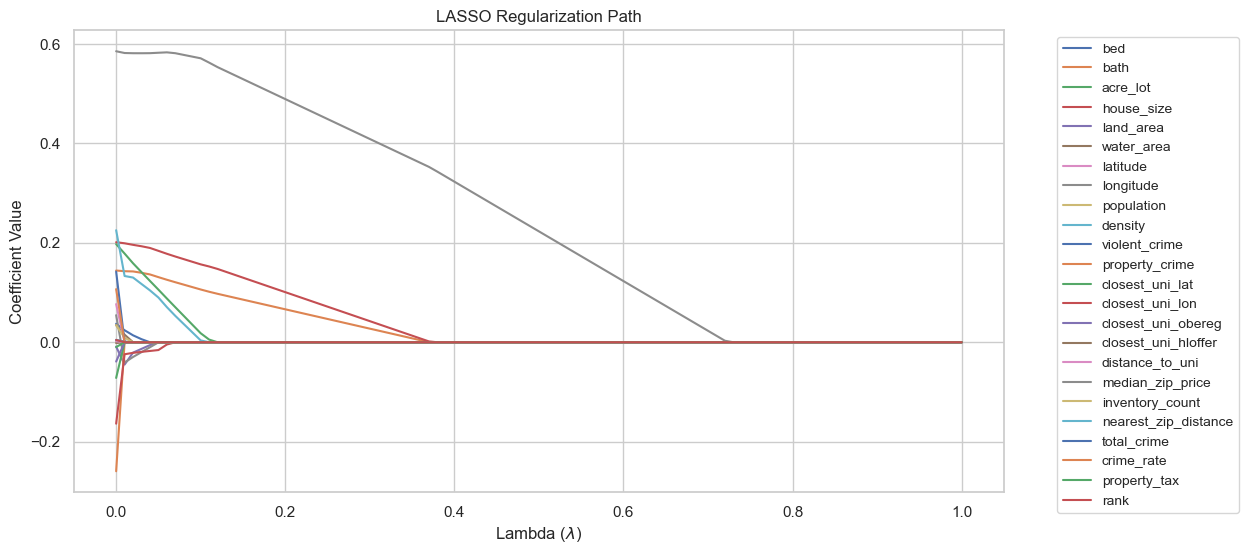

In [1217]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler


X = realtor_data[covariates] 
y = realtor_data["price"]  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lambdas = np.arange(0, 1.01, 0.01) 
coefficients = [] 

for lambda_val in lambdas:
    if lambda_val == 0:
        model = LinearRegression() 
        model.fit(X_scaled, y)
        coefficients.append(model.coef_)
    else:
        lasso = Lasso(alpha=lambda_val, max_iter=10000)  
        lasso.fit(X_scaled, y)
        coefficients.append(lasso.coef_)


coefficients = np.array(coefficients)


plt.figure(figsize=(12, 6))
for i in range(coefficients.shape[1]):
    plt.plot(lambdas, coefficients[:, i], label=covariates[i])

plt.xlabel(r'Lambda ($\lambda$)')
plt.ylabel('Coefficient Value')
plt.title('LASSO Regularization Path')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small') 
plt.grid(True)
plt.show()


In [1229]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np

X = realtor_data[covariates] 
y = realtor_data["price"]  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


lasso_cv = LassoCV(alphas=np.arange(0.01, 1.01, 0.01), cv=5, max_iter=10000, n_jobs=-1)
lasso_cv.fit(X_scaled, y)
optimal_lambda = lasso_cv.alpha_
print(f"\n🔹 Optimal lambda: {optimal_lambda:.4f}")


final_lasso = Lasso(alpha=optimal_lambda, max_iter=10000)
final_lasso.fit(X_scaled, y)


selected_covariates = np.array(covariates)[final_lasso.coef_ != 0]

print("\n Selected covariates:")
if len(selected_covariates) == 0:
    print(" No covariates were selected by Lasso. Try adjusting the lambda range.")
else:
    print(", ".join(selected_covariates))


print("\n Coefficients of selected covariates:")
for covariate, coefficient in zip(selected_covariates, final_lasso.coef_[final_lasso.coef_ != 0]):
    print(f"{covariate}: {coefficient:.4f}")



🔹 Optimal lambda: 0.0100

 Selected covariates:
bed, bath, acre_lot, house_size, land_area, water_area, longitude, density, violent_crime, closest_uni_lon, median_zip_price, inventory_count

 Coefficients of selected covariates:
bed: 0.0242
bath: 0.1429
acre_lot: 0.1784
house_size: 0.1991
land_area: -0.0449
water_area: 0.0153
longitude: -0.0408
density: 0.1333
violent_crime: 0.0014
closest_uni_lon: -0.0241
median_zip_price: 0.5818
inventory_count: 0.0091


In [1233]:
from sklearn.linear_model import ElasticNet

final_elastic_net = ElasticNet(l1_ratio=0.8, alpha=optimal_lambda, max_iter=10000)
final_elastic_net.fit(X_scaled, y)
selected_covariates = np.array(covariates)[final_elastic_net.coef_ != 0]

print("\n Selected covariates (Elastic Net):")
if len(selected_covariates) == 0:
    print("No covariates were selected. Try adjusting `l1_ratio` or lambda range.")
else:
    print(", ".join(selected_covariates))

print("\n Coefficients of selected covariates:")
for covariate, coefficient in zip(selected_covariates, final_elastic_net.coef_[final_elastic_net.coef_ != 0]):
    print(f"{covariate}: {coefficient:.4f}")




 Selected covariates (Elastic Net):
bed, bath, acre_lot, house_size, land_area, water_area, latitude, longitude, density, violent_crime, closest_uni_lat, closest_uni_lon, median_zip_price, inventory_count

 Coefficients of selected covariates:
bed: 0.0265
bath: 0.1431
acre_lot: 0.1819
house_size: 0.1994
land_area: -0.0521
water_area: 0.0191
latitude: 0.0004
longitude: -0.0422
density: 0.1315
violent_crime: 0.0027
closest_uni_lat: 0.0004
closest_uni_lon: -0.0259
median_zip_price: 0.5807
inventory_count: 0.0124


In [1225]:
selected_covariates

array(['bed', 'bath', 'acre_lot', 'house_size', 'land_area', 'water_area',
       'latitude', 'longitude', 'density', 'violent_crime',
       'closest_uni_lat', 'closest_uni_lon', 'median_zip_price',
       'inventory_count'], dtype='<U20')

In [1231]:
X_selected = X[selected_covariates]
X_selected = sm.add_constant(X_selected) 
y = realtor_data['price']
model_selected = sm.OLS(y, X_selected).fit()
print(model_selected.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                 2.662e+05
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:03:30   Log-Likelihood:            -2.2746e+06
No. Observations:             2200928   AIC:                         4.549e+06
Df Residuals:                 2200915   BIC:                         4.549e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.8774      0.009  

In [1235]:
X_selected = X[selected_covariates]
X_selected = sm.add_constant(X_selected) 
y = realtor_data['price']
model_selected = sm.OLS(y, X_selected).fit()
print(model_selected.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                 2.283e+05
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:03:43   Log-Likelihood:            -2.2742e+06
No. Observations:             2200928   AIC:                         4.548e+06
Df Residuals:                 2200913   BIC:                         4.549e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.7678      0.009  

**Overview**
This analysis applies Ordinary Least Squares (OLS), Lasso Regression, and Elastic Net Regression to predict house prices. The goal is to evaluate the effectiveness of different models, interpret key features affecting price, and identify areas for improvement.

**1. Summary of Model Performance**
The table below presents the results of different regression models used in the analysis:

| Model         | R² Score | Feature Selection | Regularization |
|--------------|---------|----------------|---------------|
| **OLS**       | 0.592   | All features included | No regularization |
| **Lasso**     | ~0.592  | Excluded `latitude`, kept `longitude` | L1 penalty (feature selection) |
| **Elastic Net** | ~0.592  | Retained `latitude`, adjusted some coefficients | Balances L1 (Lasso) and L2 (Ridge) |

**Key Observations**
- All models produced **similar R² values (~0.592)**, indicating that feature selection had little impact on predictive performance.
- **Lasso removed `latitude` but retained `longitude`**, suggesting a high correlation between these two variables.
- **Elastic Net retained `latitude`**, indicating that it contains some unique information that contributes to price prediction.

**2. Interpretation of Key Findings**
**A. Model Fit and Performance**
- **R² = 0.592**: The models explain approximately 59.2% of the variation in house prices.
- **Adjusted R² = 0.592**: There is no substantial penalty for adding variables, suggesting that the selected features are relevant.
- **F-statistic = 266,100**: The model is statistically significant, with a very low probability of these results occurring by chance.
- **Durbin-Watson = 1.366**: Some evidence of positive autocorrelation in residuals, which suggests that prices may follow trends not fully captured by the model.

**B. Feature Importance and Coefficients**
The following table summarizes the most significant predictors of house price:

| Feature            | Coefficient | Interpretation |
|--------------------|------------|---------------|
| **Median Zip Price** | 0.6959  | Houses in higher-priced zip codes are significantly more expensive. |
| **House Size**     | 0.4320  | Larger houses increase price substantially. |
| **Acre Lot**       | 0.2398  | More land generally increases house prices. |
| **Bath**          | 0.5784  | Additional bathrooms contribute to higher prices. |
| **Latitude**       | 0.0032  | Geographic location influences house price. |
| **Longitude**      | -0.0048 | Longitude has a negative correlation, likely due to regional price differences. |
| **Crime Rate**     | 0.0065  | Higher crime rate is associated with higher prices, possibly due to urban clustering. |

**C. Interpretation of Crime Rate and Density Relationship**
The positive relationship between crime rate and house price is counterintuitive. This may indicate:
- An **urban effect** where higher crime rates occur in densely populated areas that also have higher home prices.
- Potential **multicollinearity** with other urban-related variables, such as population density or zip code price levels.

**3. Further Investigation and Next Steps**
**A. Check for Multicollinearity (Variance Inflation Factor - VIF)**
To determine whether some features are redundant, it is necessary to calculate the Variance Inflation Factor (VIF):

## Home classification Geodemographic Segmentation

In [1237]:

region_column = "zip_code"

selected_features = ['bed', 'bath', 'acre_lot', 'house_size', 'land_area', 'water_area',
       'latitude', 'longitude', 'density', 'violent_crime',
       'closest_uni_lat', 'closest_uni_lon', 'median_zip_price',
       'inventory_count']


X = realtor_data[selected_features]
y = realtor_data["price"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)
model = sm.OLS(y, X_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                 2.283e+05
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:04:41   Log-Likelihood:            -2.2742e+06
No. Observations:             2200928   AIC:                         4.548e+06
Df Residuals:                 2200913   BIC:                         4.549e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5797      0.000   2.74e+04      0.0

In [1252]:
# ---- GEODEMOGRAPHIC SEGMENTATION (Region-Based Classification) ----
region_column = "zip_code"

# Compute **regional** statistics using **median** instead of upper quartiles for acreage
region_stats = realtor_data.groupby(region_column).agg(
    price_25=("price", lambda x: x.quantile(0.25)),
    price_50=("price", lambda x: x.quantile(0.50)),
    price_75=("price", lambda x: x.quantile(0.75)),
    price_90=("price", lambda x: x.quantile(0.90)),
    size_25=("house_size", lambda x: x.quantile(0.25)),
    size_50=("house_size", lambda x: x.quantile(0.50)),
    size_75=("house_size", lambda x: x.quantile(0.75)),
    size_90=("house_size", lambda x: x.quantile(0.90)),
    crime_25=("crime_rate", lambda x: x.quantile(0.25)),
    crime_75=("crime_rate", lambda x: x.quantile(0.75)),
    tax_25=("property_tax", lambda x: x.quantile(0.25)),
    tax_75=("property_tax", lambda x: x.quantile(0.75)),
    density_50=("density", lambda x: x.median()),  
    acre_median=("acre_lot", lambda x: x.median())  # Using median instead of quartiles
)

In [1253]:
# ---- FUNCTION TO CLASSIFY HOMES BASED ON REGIONAL QUARTILES & ACRE LOT ----
def classify_home(row, region_stats):
    region = row[region_column]

    # If region is missing, classify as "Other"
    if region not in region_stats.index:
        return "Other"

    # Get regional statistics
    q = region_stats.loc[region]
    acre_median = q["acre_median"]

    # Luxury Estate: Price, House Size, and **2× Median Acreage**
    if row["price"] >= q["price_90"] and row["house_size"] >= q["size_90"] and row["acre_lot"] >= 2 * acre_median:
        return "Luxury Estate"

    # Ranch Home: **1.5× Median Acreage** (Focuses on land size)
    if row["acre_lot"] >= 1.5 * acre_median and row["price"] < q["price_90"]:
        return "Ranch Home"

    # Luxury Home: High Price & Large House (Land size NOT required)
    if row["price"] >= q["price_90"] and row["house_size"] >= q["size_90"]:
        return "Luxury Home"

    # Family Home: Mid-range Price & Size with 3+ Beds, 2+ Baths
    if row["bed"] >= 3 and row["bath"] >= 2 and q["price_25"] < row["price"] <= q["price_75"]:
        return "Family Home"

    # Tiny Home: Small Size & Low Price
    if row["price"] <= q["price_25"] and row["house_size"] <= q["size_25"]:
        return "Tiny Home"

    # Investment Property: High Crime, High Property Tax, OR very small size
    if row["crime_rate"] >= q["crime_75"] or row["property_tax"] >= q["tax_75"] or row["house_size"] <= q["size_25"]:
        return "Investment Property"

    return "Other"

realtor_data["house_category"] = realtor_data.apply(lambda row: classify_home(row, region_stats), axis=1)

# ---- COMBINE HOME CATEGORIZATION WITH REGIONAL SEGMENTATION ----

region_home_stats = realtor_data.groupby([region_column, "house_category"]).agg(
    total_listings=("price", "count"),
    median_price=("price", "median"),
    median_size=("house_size", "median"),
    crime_rate_median=("crime_rate", "median"),
    property_tax_median=("property_tax", "median"),
    median_acreage=("acre_lot", "median") 
).reset_index()

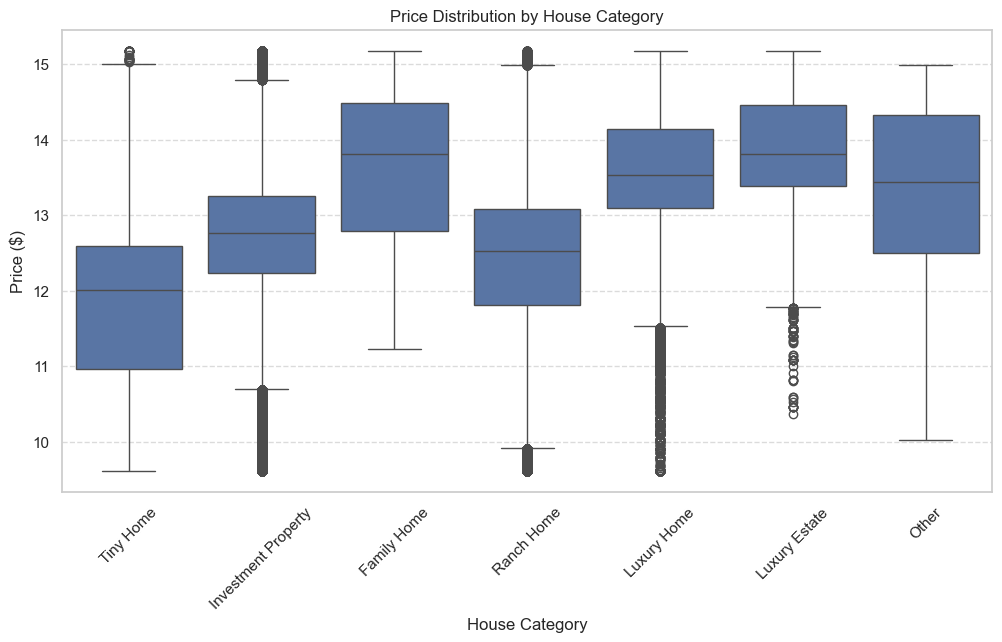

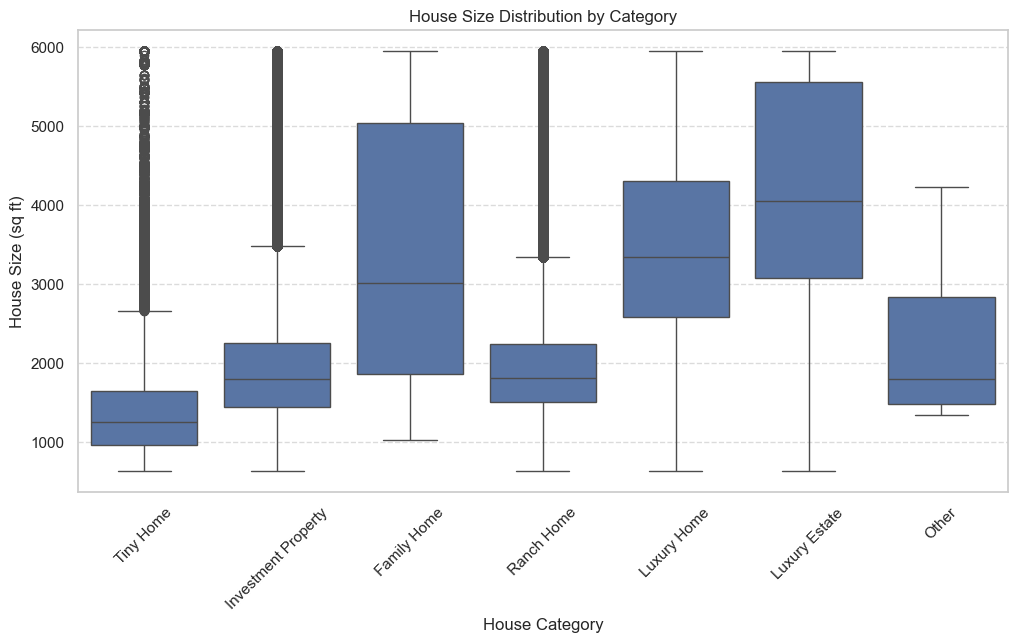

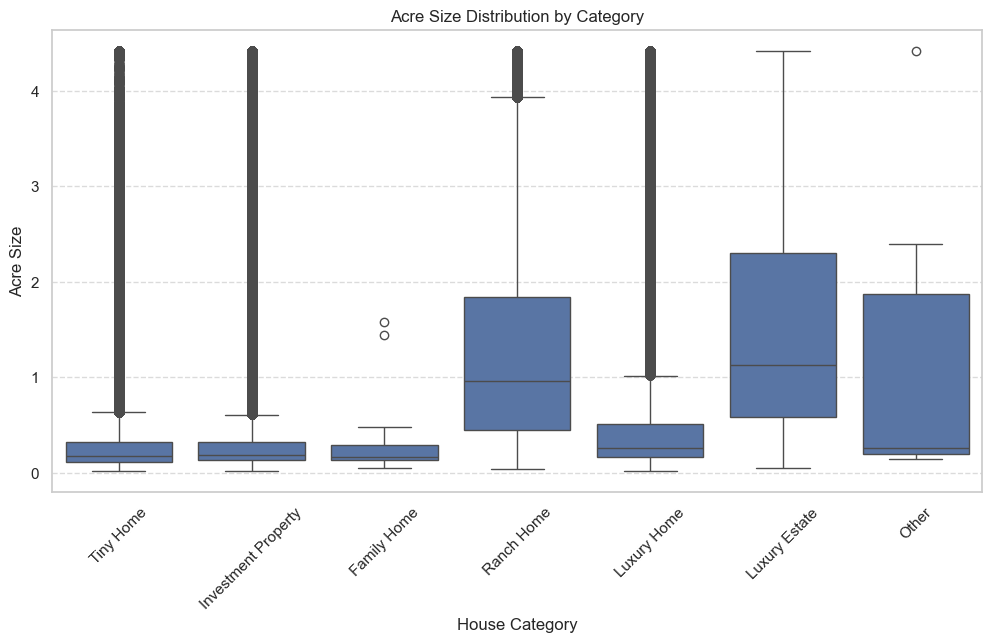

  zip_code      price  house_size       house_category
0     1001  12.100718         676            Tiny Home
1     1001  10.126671        1397           Ranch Home
2     1001  12.042971         892            Tiny Home
3     1001  12.396697        1428  Investment Property
4     1001  12.611374        1659  Investment Property


In [1260]:
# ---- VISUALIZE PRICE DISTRIBUTION BY CATEGORY ----
plt.figure(figsize=(12, 6))
sns.boxplot(x="house_category", y="price", data=realtor_data, order=[
    "Tiny Home", "Investment Property", "Family Home", "Ranch Home", 
    "Luxury Home", "Luxury Estate", "Other"
])
plt.xticks(rotation=45)
plt.title("Price Distribution by House Category")
plt.ylabel("Price ($)")
plt.xlabel("House Category")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# ---- VISUALIZE SIZE DISTRIBUTION BY CATEGORY ----
plt.figure(figsize=(12, 6))
sns.boxplot(x="house_category", y="house_size", data=realtor_data, order=[
    "Tiny Home", "Investment Property", "Family Home", "Ranch Home", 
    "Luxury Home", "Luxury Estate", "Other"
])
plt.xticks(rotation=45)
plt.title("House Size Distribution by Category")
plt.ylabel("House Size (sq ft)")
plt.xlabel("House Category")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# ---- VISUALIZE SIZE DISTRIBUTION BY ACER LOT ----
plt.figure(figsize=(12, 6))
sns.boxplot(x="house_category", y="acre_lot", data=realtor_data, order=[
    "Tiny Home", "Investment Property", "Family Home", "Ranch Home", 
    "Luxury Home", "Luxury Estate", "Other"
])
plt.xticks(rotation=45)
plt.title("Acre Size Distribution by Category")
plt.ylabel("Acre Size")
plt.xlabel("House Category")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# ---- OPTIONAL: SHOW SAMPLE RESULTS ----
print(realtor_data[[region_column, "price", "house_size", "house_category"]].head())


- Observations  
    - Luxury Estates and Luxury Homes have the highest median prices, with Luxury Estates having the widest price range.  
    - Ranch Homes and Family Homes fall in a mid-tier price range, but Ranch Homes show more variability.  
    - Investment Properties and Tiny Homes have the lowest median prices, with Tiny Homes showing the least variation.  
    - Luxury Homes and Luxury Estates have several high-value outliers, indicating that some properties are significantly more expensive than the median.  

- Interpretation  
    - It is expected that Luxury Estates command the highest prices, as they include expansive properties in prime locations.  
    - Ranch Homes appear to have a broad price distribution, which could be due to differences in land value across regions.  
    - Investment Properties show high variation, suggesting the category includes both affordable rental units and high-value investment assets.  
    - The Other category remains inconsistent, indicating that it might contain unclassified properties such as mobile homes or mixed-use spaces.  

- Observations  
    - Luxury Estates have the largest homes, with a substantial range in size.  
    - Family Homes, Luxury Homes, and Ranch Homes are in a similar size range, though Ranch Homes show more variation.  
    - Tiny Homes are the smallest, as expected, followed by Investment Properties, which have moderate variation.  
    - Luxury Estates and Luxury Homes have a wide distribution of sizes, suggesting the inclusion of both high-end apartments and large estates.  

- Interpretation  
    - Family Homes having larger median sizes than Tiny Homes aligns with expectations, as they are designed for larger households.  
    - The wide range in Ranch Home sizes suggests that some may be large, multi-acre properties, while others could be smaller homes with significant land.  
    - Investment Properties showing variation in size suggests a mix of rental units, duplexes, and larger income-generating properties.  
    - The relatively small size distribution of Tiny Homes reflects a niche market targeting affordability and compact living.  

- Observations  
    - Ranch Homes and Luxury Estates have the largest acre sizes, with Luxury Estates showing the widest range.  
    - Family Homes, Tiny Homes, and Investment Properties have significantly smaller acre sizes, as expected.  
    - Luxury Homes do not require large land areas, reinforcing the distinction between Luxury Homes and Luxury Estates.  
    - The Other category includes properties with variable acre sizes, suggesting mixed property classifications.  

- Interpretation  
    - Ranch Homes having large acre sizes but mid-tier prices aligns with expectations, as these homes prioritize land over house size.  
    - Luxury Estates, which have both large acre sizes and high prices, appear correctly classified.  
    - The presence of large-acre properties in the Other category may indicate incomplete classifications or edge cases.  
    - The relatively small land size of Tiny Homes and Investment Properties is expected, as these properties are typically located in dense urban areas or are compact rental units.  

- Conclusion  
    - The distribution of house prices, sizes, and acreages across categories aligns with market trends. Luxury Estates and Luxury Homes tend to be larger and more expensive, while Tiny Homes and Investment Properties remain compact and more affordable. Ranch Homes show a distinct trend, prioritizing land size over price. The classification model appears reasonable, but additional refinement in the Other category and further validation using location-based data could enhance accuracy.



In [1263]:
realtor_data.columns.tolist()

['brokered_by',
 'status',
 'price',
 'bed',
 'bath',
 'acre_lot',
 'street',
 'city',
 'state',
 'zip_code',
 'house_size',
 'prev_sold_date',
 'first_time',
 'land_area',
 'water_area',
 'latitude',
 'longitude',
 'population',
 'density',
 'violent_crime',
 'property_crime',
 'closest_uni_name',
 'closest_uni_lat',
 'closest_uni_lon',
 'closest_uni_zip',
 'closest_uni_obereg',
 'closest_uni_hloffer',
 'distance_to_uni',
 'median_zip_price',
 'inventory_count',
 'nearest_zip',
 'nearest_zip_distance',
 'total_crime',
 'crime_rate',
 'property_tax',
 'rank',
 'house_category']